In [1]:
# --- Block 1: Choose a folder (dialog forced on top), then auto-find "Merged_Area_Profile*.xlsx" OR "Merged_Metrics.xlsx" ---
import os, re, sys
from pathlib import Path
import tkinter as tk
from tkinter import filedialog, messagebox

DEFAULT_START = Path(
    r"C:\Users\Talaial Alina\OneDrive - UCB-O365\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy"
)

root = tk.Tk()
# make the dialog stay in front
root.attributes("-topmost", True)
root.lift()
root.focus_force()

start_dir = filedialog.askdirectory(
    title="Select folder to search for 'Merged_Area_Profile*.xlsx' or 'Merged_Metrics.xlsx'",
    initialdir=str(DEFAULT_START if DEFAULT_START.exists() else Path.home()),
    parent=root
)

if not start_dir:
    root.destroy()
    sys.exit("No folder selected.")
    
start_dir = Path(start_dir)

# Search for matching workbooks
area_profile_hits = []
metrics_hits = []

for dirpath, dirnames, filenames in os.walk(start_dir):
    for fn in filenames:
        name = fn.lower()
        # Skip temporary Excel files
        if fn.startswith("~$"):
            continue
            
        # Check for Excel files
        if name.endswith((".xlsx", ".xlsm")):
            full_path = Path(dirpath) / fn
            
            # Check for Merged_Area_Profile pattern (with or without concentration info)
            if "merged_area_profile" in name:
                area_profile_hits.append(full_path)
            
            # Check for Merged_Metrics pattern (with or without concentration info)
            # Matches both old format "Merged_Metrics.xlsx" and new format "Merged_Metrics_2pct_gelatin_25ugmL.xlsx"
            if "merged_metrics" in name:
                metrics_hits.append(full_path)

# Combine all hits for display/selection
all_hits = []
for hit in area_profile_hits:
    all_hits.append(("area_profile", hit))
for hit in metrics_hits:
    all_hits.append(("metrics", hit))

if not all_hits:
    messagebox.showinfo(
        "Not found", 
        f"No 'Merged_Area_Profile*.xlsx' or 'Merged_Metrics.xlsx' files found under:\n{start_dir}", 
        parent=root
    )
    root.destroy()
    sys.exit(0)

# Sort by modification time (most recent first)
all_hits.sort(key=lambda x: x[1].stat().st_mtime, reverse=True)

# Create message showing what was found
file_type, chosen = all_hits[0]
file_type_str = "Area Profile" if file_type == "area_profile" else "Metrics"

# Count files by type
area_count = len(area_profile_hits)
metrics_count = len(metrics_hits)

# Persist for Block 2
sel_file = Path.cwd() / "selected_area_profile.txt"
sel_file.write_text(str(chosen), encoding="utf-8")

# Also save the file type for later reference if needed
type_file = Path.cwd() / "selected_file_type.txt"
type_file.write_text(file_type, encoding="utf-8")

# Keep metrics_hits available for the bar plot code
# (The bar plot code expects metrics_hits to be defined)

messagebox.showinfo(
    "Workbook selected",
    f"Found:\n"
    f"  • {area_count} Merged_Area_Profile file(s)\n"
    f"  • {metrics_count} Merged_Metrics.xlsx file(s)\n\n"
    f"Using most recent ({file_type_str}):\n{chosen}\n\n"
    f"(Path saved to {sel_file})",
    parent=root
)

root.destroy()

print(f"USING: {chosen} (Type: {file_type_str})")
print(f"Total files found: {len(all_hits)} ({area_count} Area Profile, {metrics_count} Metrics)")

# Display all found files for reference
if area_profile_hits:
    print(f"\nArea Profile files found:")
    for i, path in enumerate(area_profile_hits, 1):
        print(f"  {i}. {path}")

if metrics_hits:
    print(f"\nMetrics files found:")
    for i, path in enumerate(metrics_hits, 1):
        print(f"  {i}. {path}")

USING: C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Metrics\Merged_Metrics_2pct_gelatin_200ugmL.xlsx (Type: Metrics)
Total files found: 4 (2 Area Profile, 2 Metrics)

Area Profile files found:
  1. C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Area_Profile\Merged_Area_Profile_2pct_gelatin_200ugmL.xlsx
  2. C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Area_Profile\Merged_Area_Profile_2pct_gelatin_25ugmL.xlsx

Metrics files found:
  1. C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Metrics\Merged_Met

Processing 2 Area Profile files
Detected 8% gelatin - including all duty cycles

Processing: Merged_Area_Profile_2pct_gelatin_200ugmL.xlsx
  Detected concentration: 200.0 ug/mL
  Particle types found: DBPC HMSN, MSN

  Processing DBPC HMSN data...

  Processing merged file at 200.0 ug/mL:
  Particle type: DBPC HMSN
  Available sheets: 12
    28C: Found 12 sheets

  Processing MSN data...

  Processing merged file at 200.0 ug/mL:
  Particle type: MSN
  Available sheets: 12
    28C: Found 12 sheets

Processing: Merged_Area_Profile_2pct_gelatin_25ugmL.xlsx
  Detected concentration: 25.0 ug/mL
  Particle types found: DBPC HMSN, MSN

  Processing DBPC HMSN data...

  Processing merged file at 25.0 ug/mL:
  Particle type: DBPC HMSN
  Available sheets: 9
    28C: Found 9 sheets

  Processing MSN data...

  Processing merged file at 25.0 ug/mL:
  Particle type: MSN
  Available sheets: 9
    28C: Found 9 sheets

Data Summary:
  DBPC HMSN: 2 concentration(s) - [25.0, 200.0] ug/mL
  MSN: 2 concen

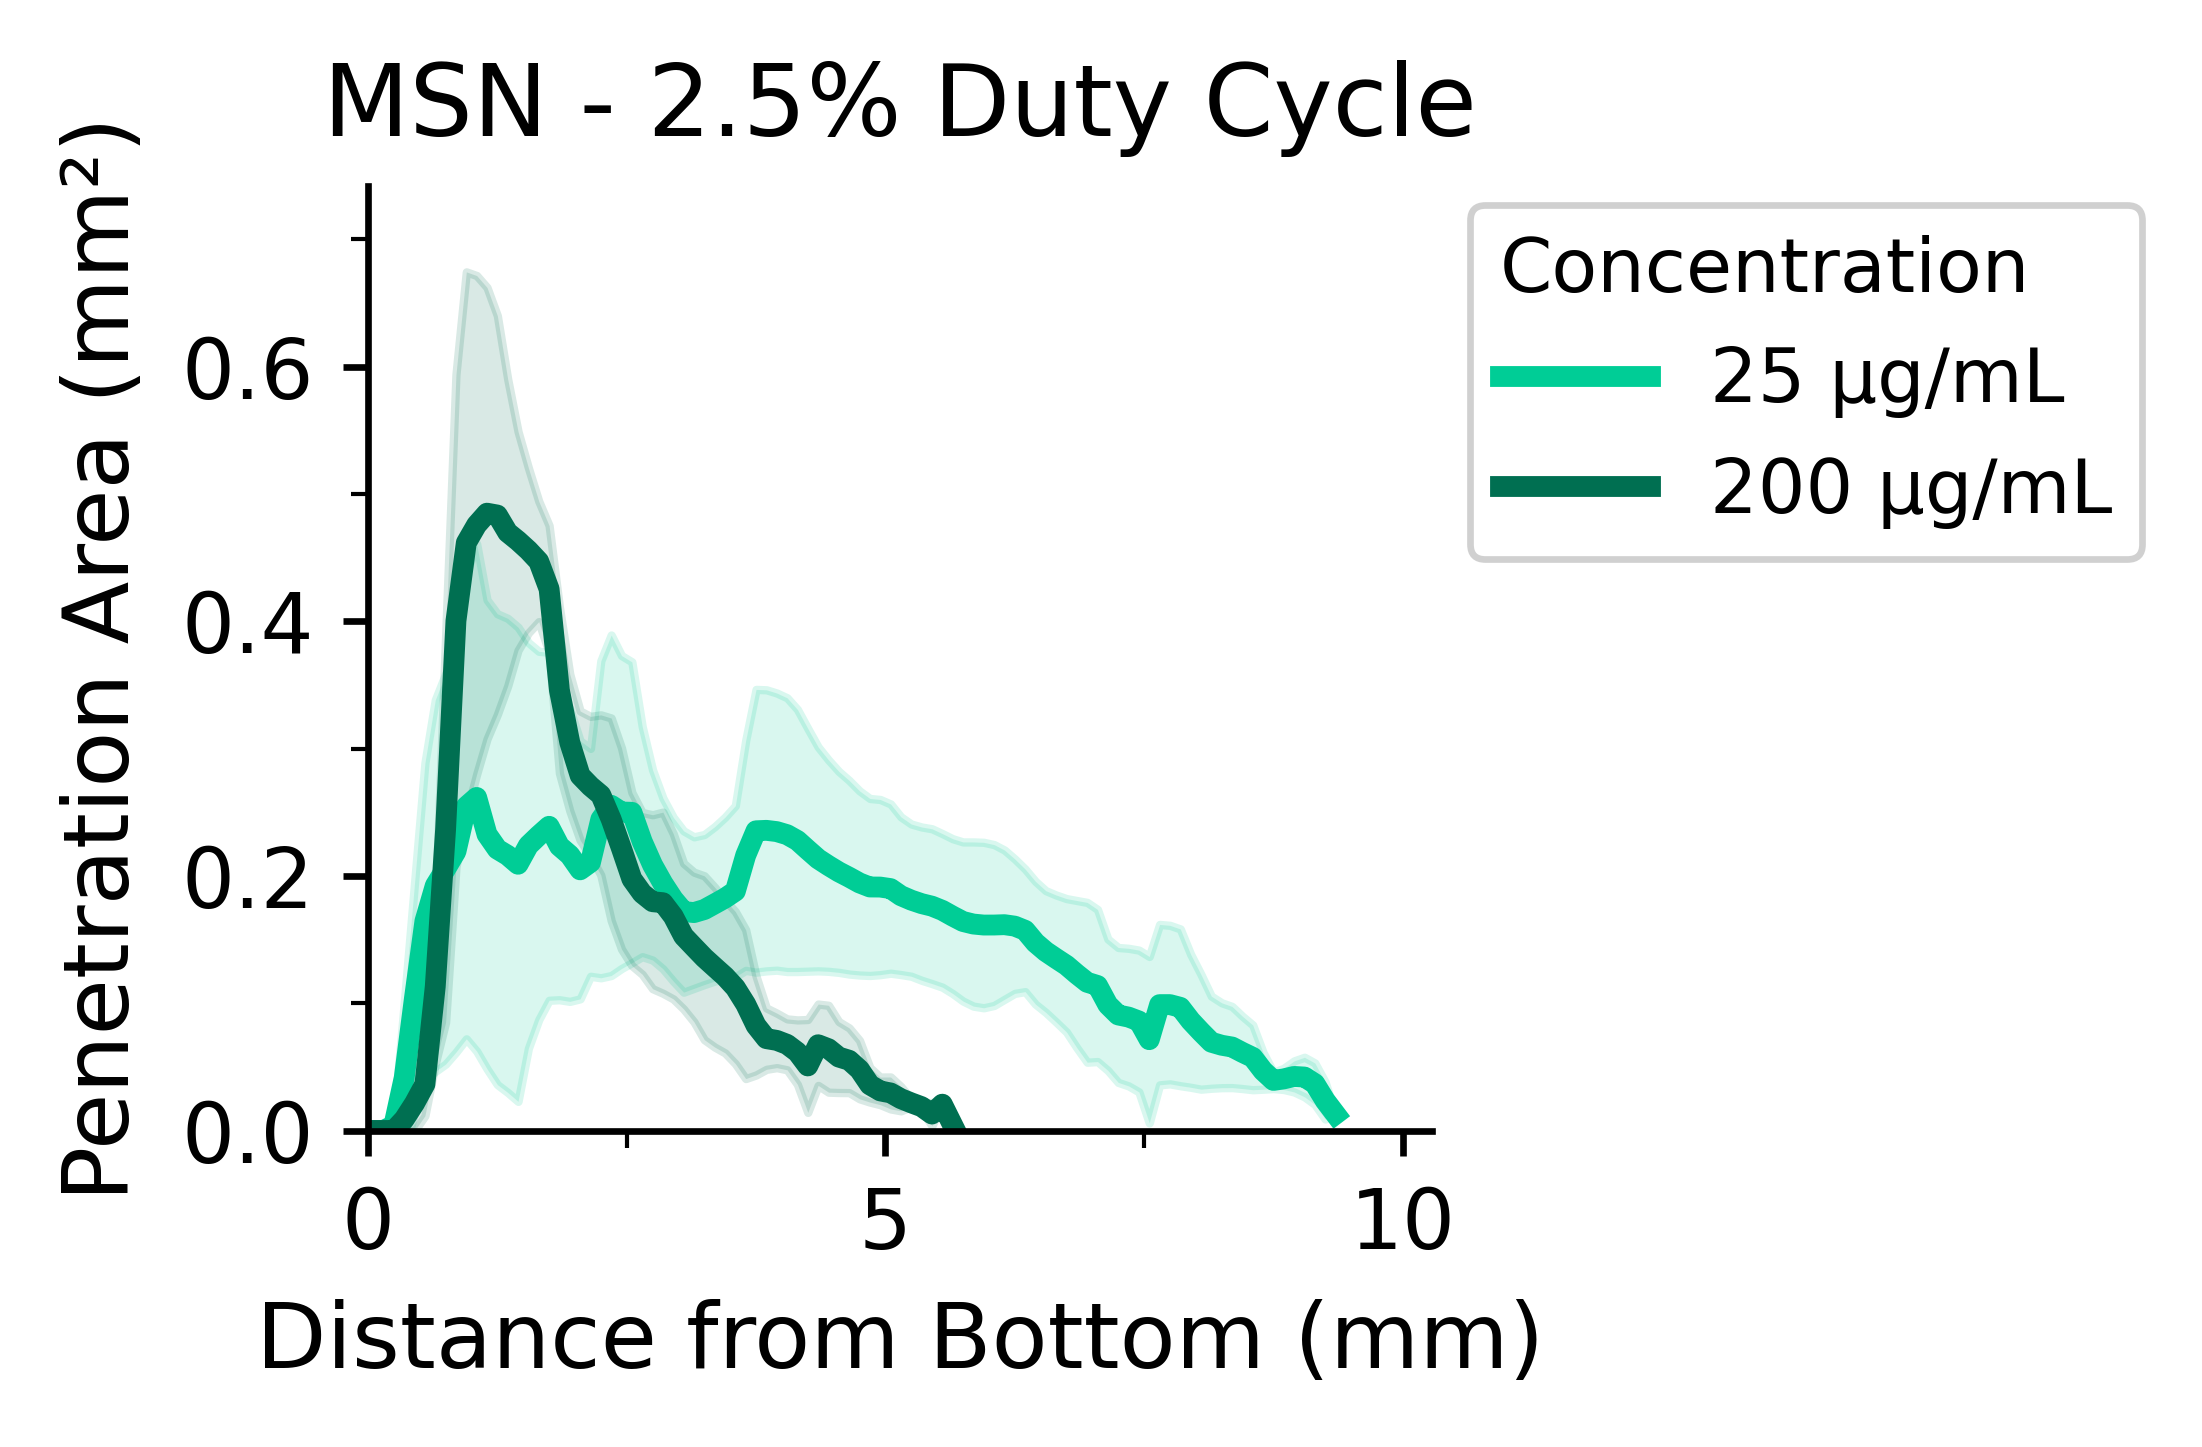

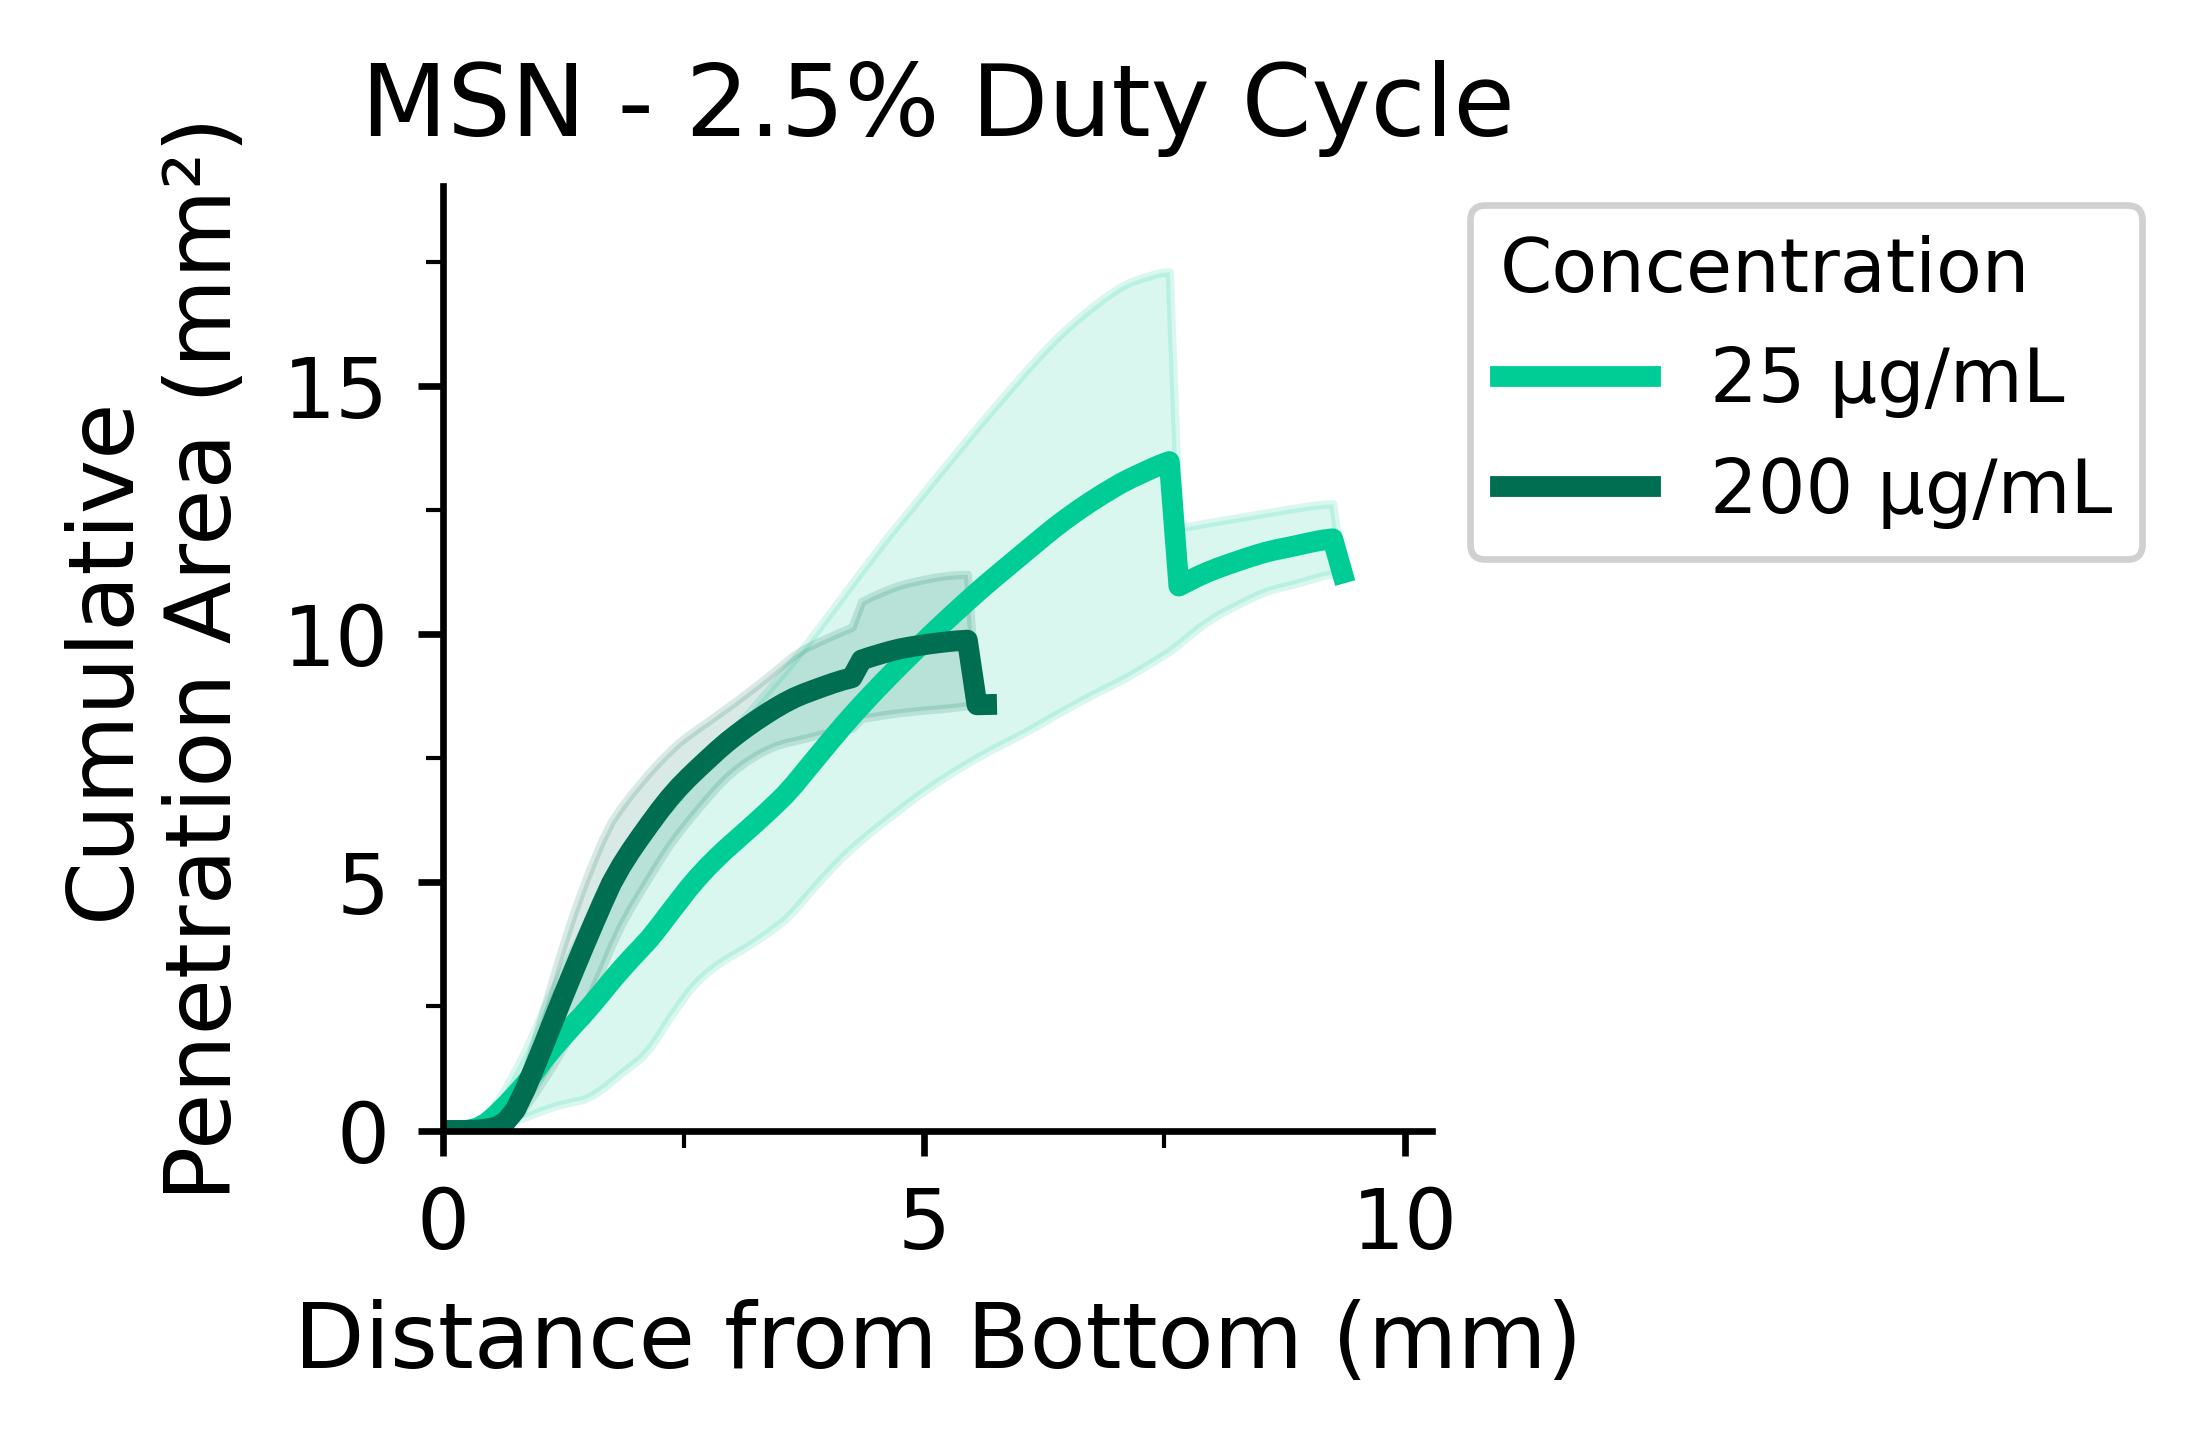

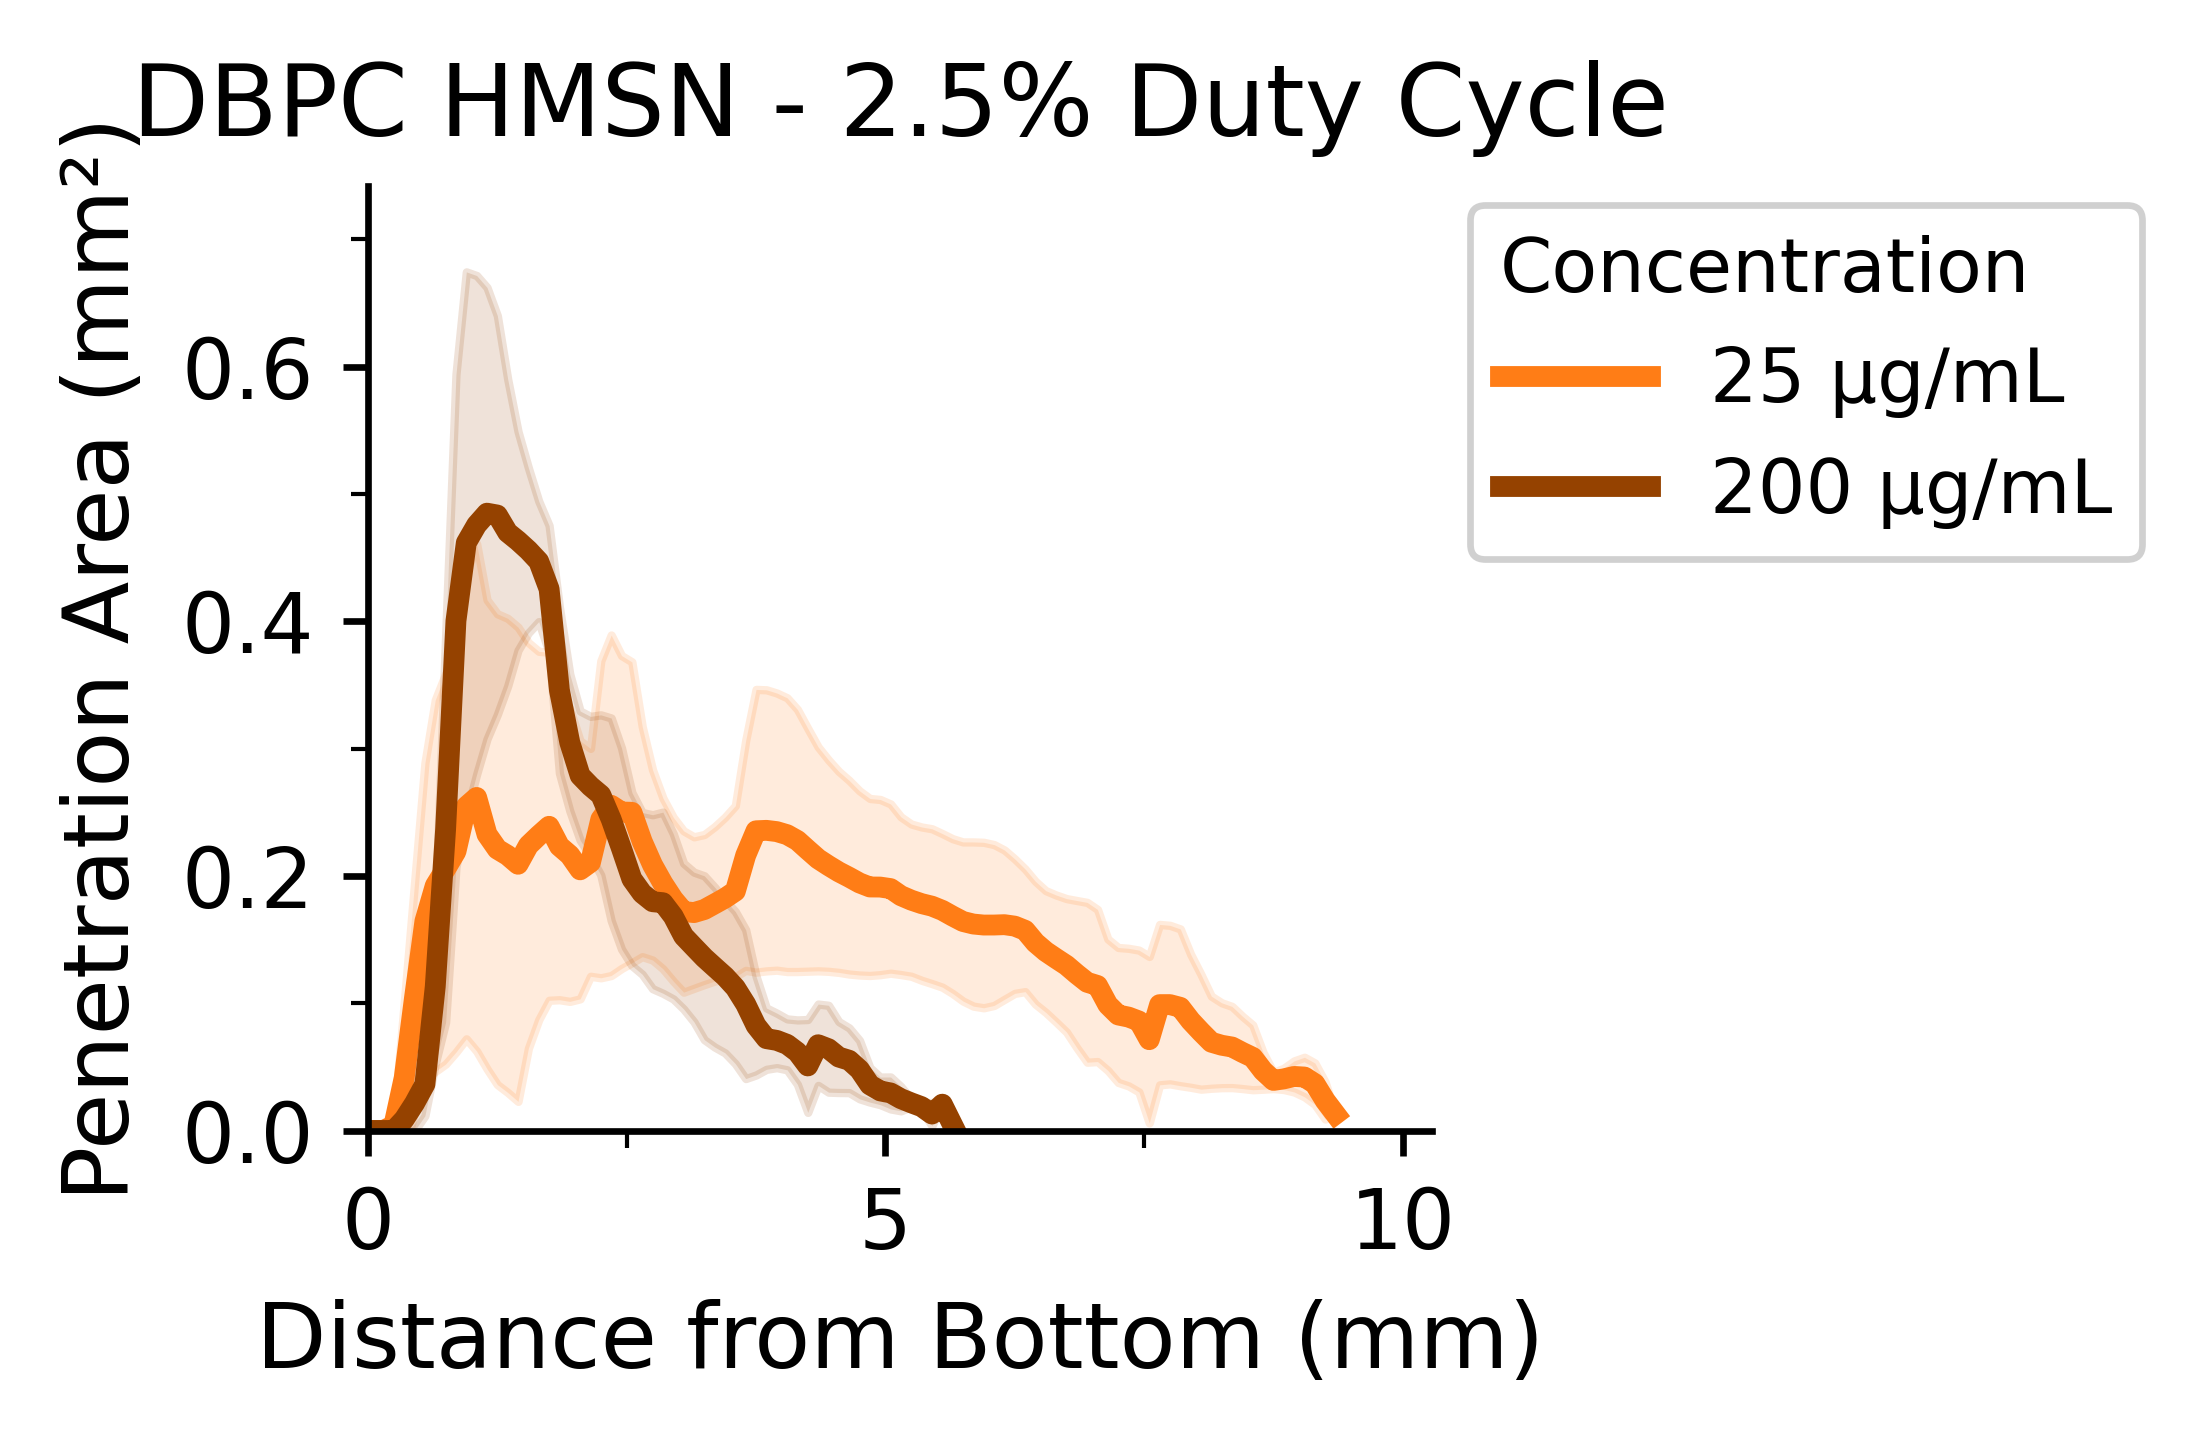

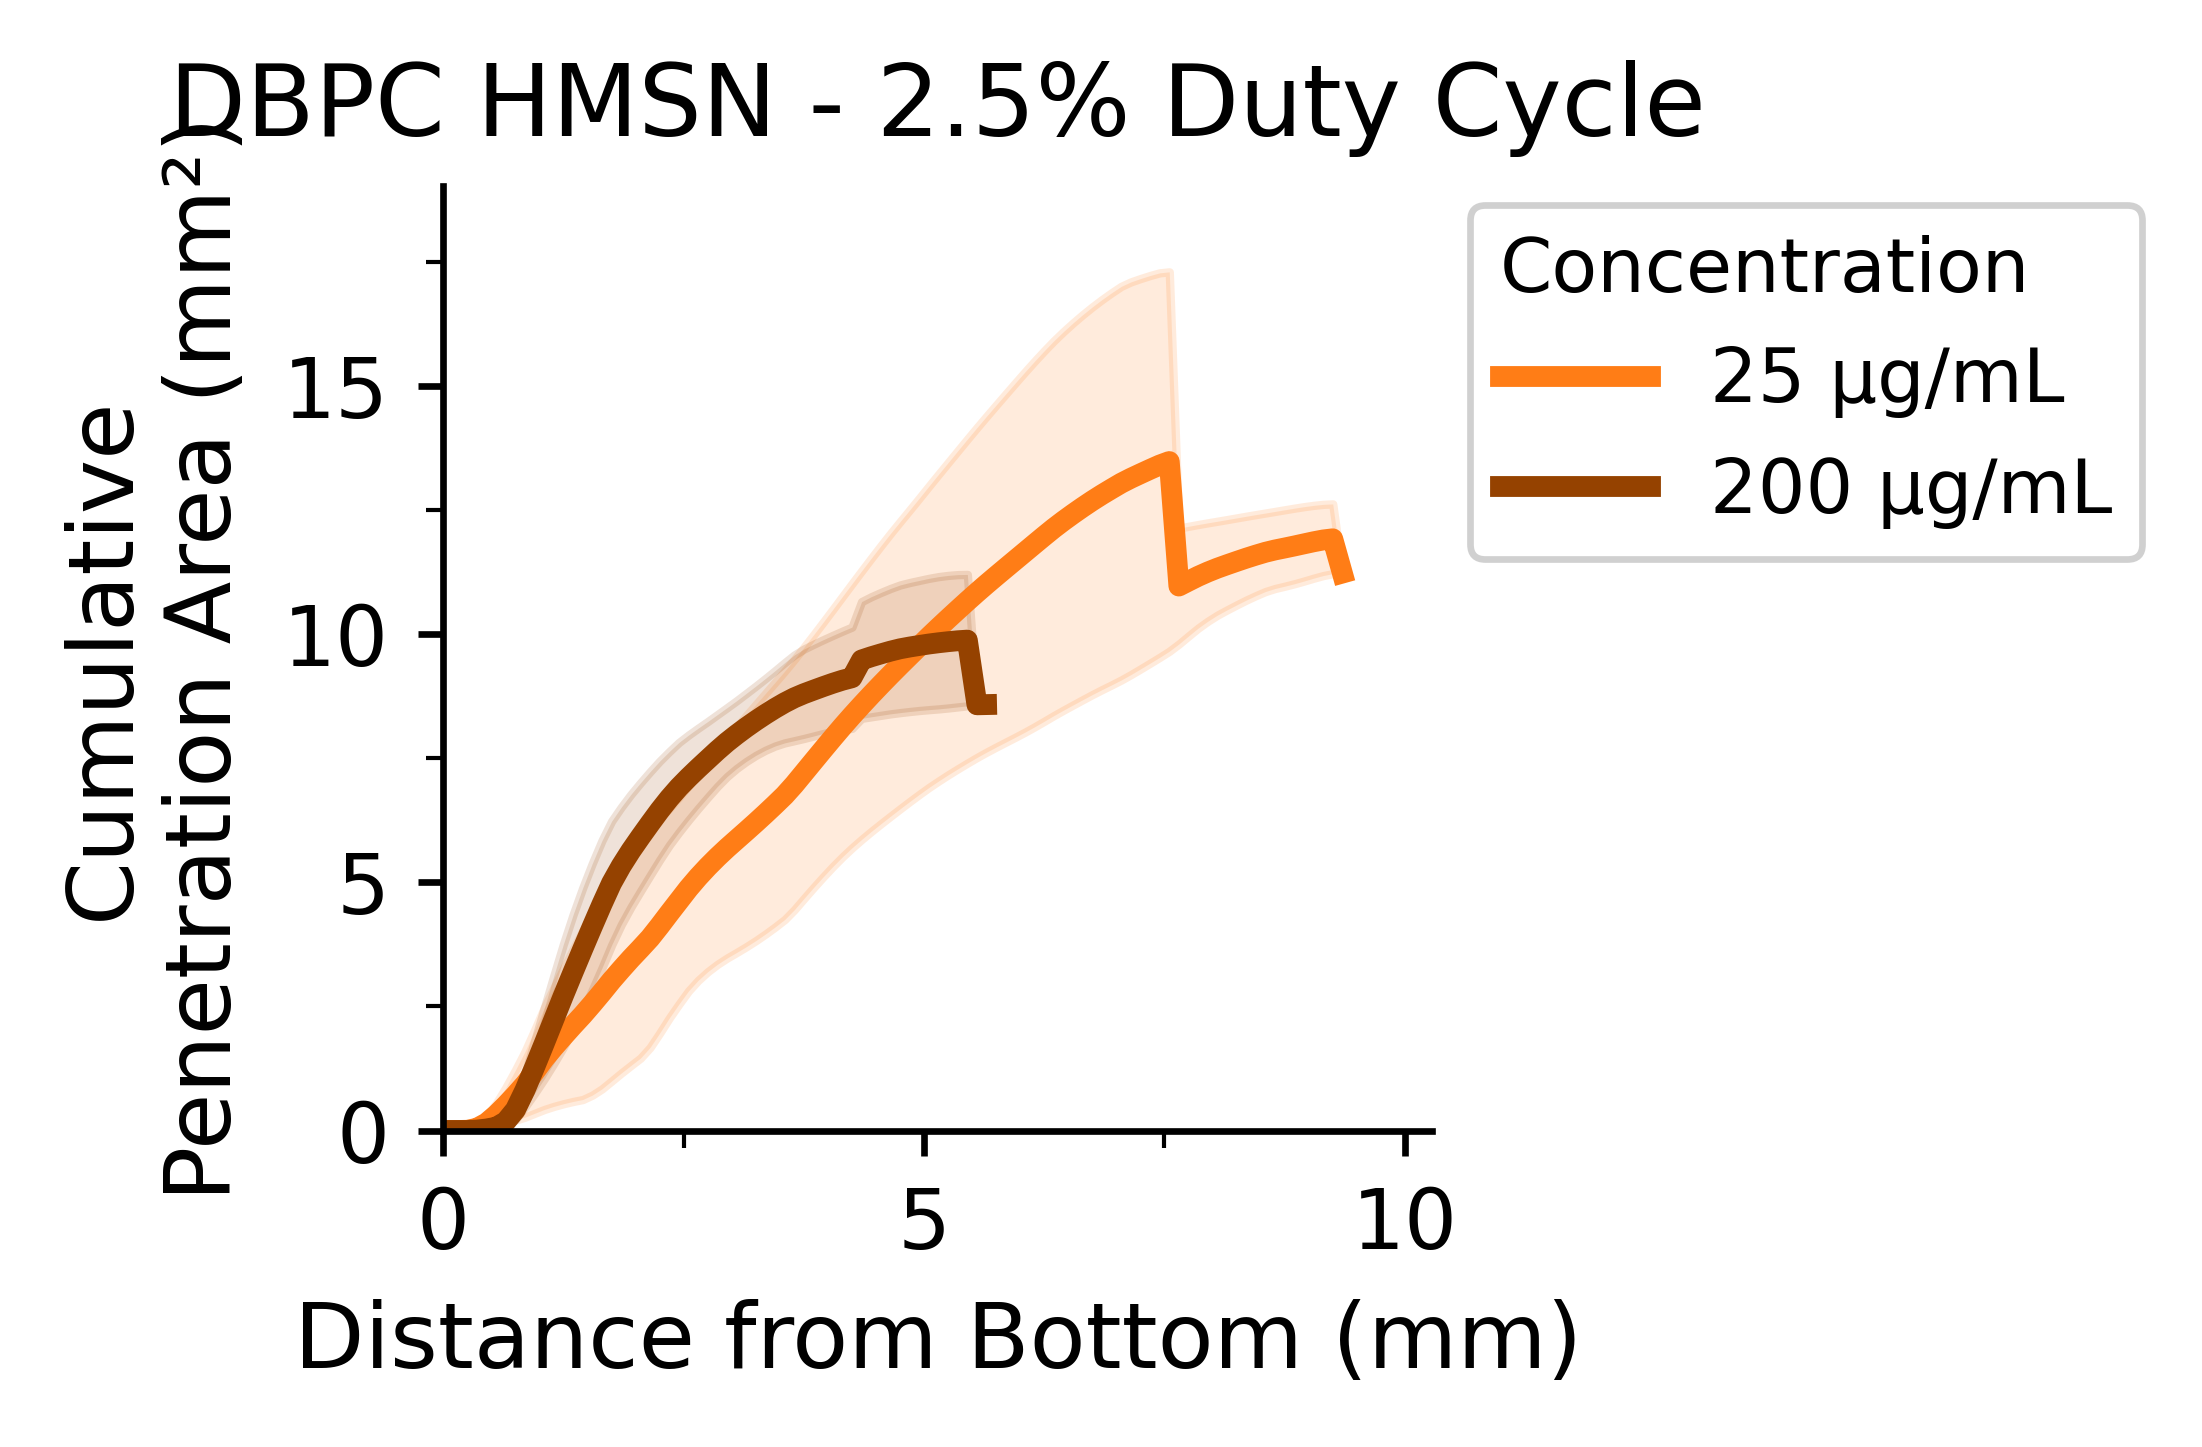

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
import re, sys
import matplotlib as mpl
import colorsys

# ========= User controls =========
CUM_MODE = "sheet"  # "sheet" or "trapz"
SAVE = True  # Save figures and CSVs
FORCE_DUTY_CYCLE_PLOTS = False  # Set to True to always create duty cycle comparison plots
DEFAULT_CONCENTRATION = 200.0  # Default particle concentration (ug/mL) if not detected in path/filename

# ========= HARDCODED PLOT LIMITS =========
AREA_Y_MAX_BASE = 0.34  # mm²
CUMULATIVE_Y_MAX_BASE = 12.76  # mm²
X_MAX_BASE = 9.55  # mm

# Add padding
PADDING_FACTOR = 1.1
AREA_Y_MAX = AREA_Y_MAX_BASE * PADDING_FACTOR
CUMULATIVE_Y_MAX = CUMULATIVE_Y_MAX_BASE * PADDING_FACTOR
X_MAX = X_MAX_BASE * PADDING_FACTOR

# Get gelatin and particle concentration from path
def get_gelatin_percentage(filepath):
    """Extract gelatin percentage from full file path"""
    path_str = str(filepath)
    if "2%" in path_str or "2 percent" in path_str.lower():
        return 2
    elif "4%" in path_str or "4 percent" in path_str.lower():
        return 4
    elif "8%" in path_str or "8 percent" in path_str.lower():
        return 8
    return 8

def get_particle_concentration(filepath):
    """Extract particle concentration (ug/mL) from full file path or filename"""
    path_str = str(filepath)
    
    # Pattern 1: From path like "25 ug-mL"
    particle_match = re.search(r'(\d+(?:\.\d+)?)\s*ug-ml', path_str, re.IGNORECASE)
    if particle_match:
        return float(particle_match.group(1))
    
    # Pattern 2: From merged filename like "Merged_Area_Profile_2pct_gelatin_25ugmL.xlsx"
    filename_match = re.search(r'_(\d+(?:\.\d+)?)ugml', path_str.lower())
    if filename_match:
        return float(filename_match.group(1))
    
    # Default: Assume DEFAULT_CONCENTRATION ug/mL if no concentration found
    return DEFAULT_CONCENTRATION

def get_all_particle_types_from_sheets(excel_path):
    """Extract ALL particle types present in the Excel file"""
    particle_types = []
    try:
        xls = pd.ExcelFile(excel_path)
        sheet_names = xls.sheet_names
        
        # Check ALL sheets for particle type prefixes
        has_d = any(sheet.startswith('D_') for sheet in sheet_names)
        has_m = any(sheet.startswith('M_') for sheet in sheet_names)
        has_h = any(sheet.startswith('H_') for sheet in sheet_names)
        
        if has_d:
            particle_types.append('DBPC HMSN')
        if has_m:
            particle_types.append('MSN')
        if has_h:
            particle_types.append('HMSN')
            
    except Exception as e:
        print(f"    Warning: Could not read sheets from {Path(excel_path).name}: {e}")
    
    return particle_types if particle_types else ['Unknown']

def get_particle_type_from_path(filepath):
    """Extract particle type from file path, filename, or sheet names"""
    path_str = str(filepath)
    
    # Check for full names in path
    if 'DBPC HMSN' in path_str or 'DBPC-HMSN' in path_str:
        return 'DBPC HMSN'
    elif 'MSN' in path_str and 'HMSN' not in path_str:
        return 'MSN'
    elif 'HMSN' in path_str and 'DBPC' not in path_str:
        return 'HMSN'
    
    # If it's an Excel file, check sheet names inside
    if str(filepath).endswith('.xlsx') or str(filepath).endswith('.xls'):
        types = get_all_particle_types_from_sheets(filepath)
        # For backwards compatibility, return first type found
        return types[0]
    
    return 'Unknown'

# Define base colors for particle types
PARTICLE_COLORS = {
    "MSN": "#009E73",       # Green
    "DBPC HMSN": "#D55E00", # Orange
    "HMSN": "#0072B2"       # Blue
}

DUTY_CYCLE_MAP = {
    "0C": "0%",
    "5C": "0.5%",
    "11C": "1%",
    "28C": "2.5%",
    "40C": "3.6%"
}

# Duty-cycle-specific lightness tuning (for duty cycle plots)
DUTY_SHADE_MAP = {
    '0%': 1.3,     # Lightest
    '0.5%': 1.15,
    '1%': 1.0,     # Neutral / base color
    '2.5%': 0.85,
    '3.6%': 0.7    # Darkest
}

# Concentration-based color shading (for concentration plots)
def get_concentration_color(base_color, concentration, conc_min, conc_max):
    """Apply shading based on concentration (lighter for low, darker for high)"""
    if conc_max == conc_min:
        return base_color
    
    # Normalize concentration to 0-1 range
    normalized = (concentration - conc_min) / (conc_max - conc_min)
    
    # Map to intensity range (1.3 = lightest, 0.7 = darkest)
    intensity = 1.3 - (normalized * 0.6)
    
    rgb_base = mpl.colors.to_rgb(base_color)
    h, l, s = colorsys.rgb_to_hls(*rgb_base)
    l = max(0, min(1, l * intensity))
    return colorsys.hls_to_rgb(h, l, s)

def get_duty_cycle_color(base_color, duty_cycle):
    """Apply shading based on duty cycle"""
    intensity = DUTY_SHADE_MAP.get(duty_cycle, 1.0)
    rgb_base = mpl.colors.to_rgb(base_color)
    h, l, s = colorsys.rgb_to_hls(*rgb_base)
    l = max(0, min(1, l * intensity))
    return colorsys.hls_to_rgb(h, l, s)

# ========= Find all area profile files =========
if 'area_profile_hits' not in locals():
    print("No area_profile_hits found. Run Block 1 first!")
    sys.exit(1)

if not area_profile_hits:
    print("No Area Profile files found")
    sys.exit(1)

# ADD THIS LINE:
save_dir = area_profile_hits[0].parent if area_profile_hits else Path.cwd()

print(f"Processing {len(area_profile_hits)} Area Profile files")

# Get gelatin percentage from first file
gel_percentage = get_gelatin_percentage(area_profile_hits[0])

# Determine which duty cycles to use
if gel_percentage in [2, 4]:
    CYCLES_TO_PLOT = ["0C", "5C", "11C", "28C"]
    print(f"Detected {gel_percentage}% gelatin - excluding 3.6% duty cycle")
else:
    CYCLES_TO_PLOT = ["0C", "5C", "11C", "28C", "40C"]
    print(f"Detected {gel_percentage}% gelatin - including all duty cycles")

# ========= Helpers =========
PANEL_W_IN, PANEL_H_IN, DPI = 3.77, 2.50, 600
AXIS_FS, TICK_FS, LEGEND_FS = 11, 10, 9

def small_panel_ax():
    fig, ax = plt.subplots(figsize=(PANEL_W_IN, PANEL_H_IN), dpi=DPI)
    ax.grid(False)
    ax.tick_params(axis='both', which='major', labelsize=TICK_FS, length=3, width=0.8, direction='out')
    ax.tick_params(axis='both', which='minor', length=2, width=0.5, direction='out')
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return fig, ax

def small_legend(ax, *args, **kwargs):
    leg = ax.legend(*args, fontsize=LEGEND_FS, title_fontsize=LEGEND_FS,
                    frameon=True, fancybox=True, framealpha=1.0, alignment='left', **kwargs)
    fr = leg.get_frame()
    fr.set_edgecolor("#D0D0D0")
    fr.set_linewidth(0.8)
    if leg.get_title():
        leg.get_title().set_ha('left')
        leg.get_title().set_position((0, 0))
    return leg

def cumtrapz(x, y):
    """Cumulative trapezoidal integration"""
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    out = np.zeros_like(x)
    out[1:] = np.cumsum(0.5 * (y[1:] + y[:-1]) * np.diff(x))
    return out

def load_one(excel_path, sheet):
    """Load data from a single sheet"""
    df = pd.read_excel(excel_path, sheet_name=sheet).dropna(how='all').dropna(axis=1, how='all')
    df = df.rename(columns=lambda c: c.strip() if isinstance(c, str) else c)
    
    col_x = next((c for c in df.columns if c.lower() == "distance (mm)"), None)
    col_a = next((c for c in df.columns if c.lower() == "area (mm²)"), None)
    col_c = next((c for c in df.columns if c.lower() == "cumulative area (mm²)"), None)
    
    if col_x is None or col_a is None:
        num = df.select_dtypes(include="number").columns.tolist()
        if len(num) < 2: 
            raise ValueError(f"Cannot infer columns in {sheet}")
        if col_x is None: col_x = num[0]
        if col_a is None: col_a = num[1]
        if col_c is None and len(num) > 2:
            col_c = num[2]
    
    cols_to_extract = [col_x, col_a]
    if col_c:
        cols_to_extract.append(col_c)
    
    df = df[cols_to_extract].copy()
    df = df.apply(pd.to_numeric, errors="coerce").dropna(subset=[col_x, col_a])
    df = df.sort_values(col_x).drop_duplicates(subset=col_x)
    
    x = df[col_x].to_numpy()
    a = df[col_a].to_numpy()
    c_sheet = df[col_c].to_numpy() if col_c else None
    
    return x, a, c_sheet

def process_merged_file(excel_path, particle_conc, particle_type, cycles_to_plot):
    """Process a merged file for a specific particle type"""
    xls = pd.ExcelFile(excel_path)
    sheet_names = xls.sheet_names
    
    print(f"\n  Processing merged file at {particle_conc} ug/mL:")
    print(f"  Particle type: {particle_type}")
    print(f"  Available sheets: {len(sheet_names)}")
    
    # Organize sheets by cycle
    cycle_data = {}  # {cycle_tag: [sheet_names]}
    
    for sheet in sheet_names:
        # Extract cycle from sheet name (format: D_G2_P25_28C_R6)
        cycle_match = re.search(r'(\d+)C_R', sheet)
        if not cycle_match:
            continue
        
        cycle_num = int(cycle_match.group(1))
        cycle_tag = f"{cycle_num}C"
        
        if cycle_tag not in cycles_to_plot:
            continue
        
        if cycle_tag not in cycle_data:
            cycle_data[cycle_tag] = []
        
        cycle_data[cycle_tag].append(sheet)
    
    # Process each cycle
    results = {}  # {cycle_tag: data}
    
    for cycle_tag, rep_sheets in cycle_data.items():
        print(f"    {cycle_tag}: Found {len(rep_sheets)} sheets")
        
        rep_data = []
        for sheet in rep_sheets:
            try:
                x, a, c_sheet = load_one(excel_path, sheet)
                rep_data.append({
                    "sheet": sheet,
                    "x": x,
                    "area": a,
                    "cum_sheet": c_sheet,
                    "cum_trap": cumtrapz(x, a)
                })
            except Exception as e:
                print(f"      Error loading {sheet}: {e}")
                continue
        
        if not rep_data:
            continue
        
        # Calculate endpoint cumulative area
        for d in rep_data:
            if CUM_MODE.lower() == "sheet" and d["cum_sheet"] is not None:
                d["endpoint_cum"] = d["cum_sheet"][-1]
            else:
                d["endpoint_cum"] = d["cum_trap"][-1]
        
        # Select top 3
        rep_data_sorted = sorted(rep_data, key=lambda x: x["endpoint_cum"], reverse=True)
        top_3_rep_data = rep_data_sorted[:3]
        
        # Create grid and stats
        grid = np.unique(np.concatenate([d["x"] for d in top_3_rep_data]))
        
        Y_area = np.vstack([
            np.interp(grid, d["x"], d["area"], left=np.nan, right=np.nan)
            for d in top_3_rep_data
        ])
        area_mean = np.nanmean(Y_area, axis=0)
        area_sd = np.nanstd(Y_area, axis=0)
        
        if CUM_MODE.lower() == "sheet":
            Y_cum = []
            for d in top_3_rep_data:
                c = d["cum_sheet"] if d["cum_sheet"] is not None else d["cum_trap"]
                Y_cum.append(np.interp(grid, d["x"], c, left=np.nan, right=np.nan))
            Y_cum = np.vstack(Y_cum)
        else:
            Y_cum = np.vstack([
                np.interp(grid, d["x"], d["cum_trap"], left=np.nan, right=np.nan)
                for d in top_3_rep_data
            ])
        cum_mean = np.nanmean(Y_cum, axis=0)
        cum_sd = np.nanstd(Y_cum, axis=0)
        
        results[cycle_tag] = {
            "grid": grid,
            "area_mean": area_mean,
            "area_sd": area_sd,
            "cum_mean": cum_mean,
            "cum_sd": cum_sd
        }
    
    return results

# ========= Process all files and organize by particle type and concentration =========
# ========= Process all files and organize by particle type and concentration =========
all_data = {}  # Structure: {particle_type: {concentration: {cycle: data}}}

for filepath in area_profile_hits:
    particle_conc = get_particle_concentration(filepath)
    
    # Get ALL particle types in this file
    particle_types = get_all_particle_types_from_sheets(filepath)
    
    print(f"\nProcessing: {filepath.name}")
    print(f"  Detected concentration: {particle_conc} ug/mL")
    print(f"  Particle types found: {', '.join(particle_types)}")
    
    # Process EACH particle type separately
    for particle_type in particle_types:
        print(f"\n  Processing {particle_type} data...")
        
        # Process the merged file for this specific particle type
        cycle_results = process_merged_file(filepath, particle_conc, particle_type, CYCLES_TO_PLOT)
        
        # Organize into our main data structure
        if particle_type not in all_data:
            all_data[particle_type] = {}
        all_data[particle_type][particle_conc] = cycle_results

if not all_data:
    sys.exit("No data could be processed!")

print(f"\n{'='*60}")
print("Data Summary:")
for particle_type, conc_dict in all_data.items():
    concentrations = sorted(conc_dict.keys())
    print(f"  {particle_type}: {len(concentrations)} concentration(s) - {concentrations} ug/mL")
print(f"{'='*60}")

# ========= DECISION: Which type of plots to create? =========
# First, calculate GLOBAL limits across ALL particle types and concentrations
print("\nCalculating global plot limits across all data...")
global_max_area = 0
global_max_cum = 0
global_max_x = 0

for particle_type, conc_dict in all_data.items():
    for conc, cycle_dict in conc_dict.items():
        for cycle_tag, data in cycle_dict.items():
            grid = data["grid"]
            area_mean = data["area_mean"]
            area_sd = data["area_sd"]
            cum_mean = data["cum_mean"]
            cum_sd = data["cum_sd"]
            
            global_max_x = max(global_max_x, np.nanmax(grid))
            global_max_area = max(global_max_area, np.nanmax(area_mean + area_sd))
            global_max_cum = max(global_max_cum, np.nanmax(cum_mean + cum_sd))

# Apply padding
GLOBAL_X_MAX = global_max_x * PADDING_FACTOR
GLOBAL_AREA_Y_MAX = global_max_area * PADDING_FACTOR
GLOBAL_CUM_Y_MAX = global_max_cum * PADDING_FACTOR

print(f"Global limits (with {PADDING_FACTOR}x padding):")
print(f"  X max: {GLOBAL_X_MAX:.3f} mm")
print(f"  Area Y max: {GLOBAL_AREA_Y_MAX:.3f} mm²")
print(f"  Cumulative Y max: {GLOBAL_CUM_Y_MAX:.3f} mm²")

def create_concentration_comparison_plots(particle_type, conc_dict, base_color):
    """Create plots comparing different concentrations at same duty cycle"""
    concentrations = sorted(conc_dict.keys())
    
    if not concentrations or len(concentrations) < 2:
        return False
    
    conc_min, conc_max = min(concentrations), max(concentrations)
    
    print(f"\n{particle_type}: Creating concentration comparison plots ({len(concentrations)} concentrations)")
    
    # Create one plot per duty cycle
    for cycle_tag in CYCLES_TO_PLOT:
        duty_cycle = DUTY_CYCLE_MAP[cycle_tag]
        
        figA, axA = small_panel_ax()
        figC, axC = small_panel_ax()
        
        legend_handles = []
        legend_labels = []
        has_data = False
        
        # Plot all concentrations for this duty cycle
        for conc in concentrations:
            if cycle_tag not in conc_dict[conc]:
                continue
            
            has_data = True
            data = conc_dict[conc][cycle_tag]
            color = get_concentration_color(base_color, conc, conc_min, conc_max)
            
            # Plot area profile
            grid = data["grid"]
            area_mean = data["area_mean"]
            area_sd = data["area_sd"]
            m_area = np.isfinite(area_mean)
            
            line_area = axA.plot(grid[m_area], area_mean[m_area], 
                                 color=color, lw=2.5, label=f"{int(conc)} µg/mL")[0]
            axA.fill_between(grid[m_area], 
                              (area_mean - area_sd)[m_area], 
                              (area_mean + area_sd)[m_area], 
                              color=color, alpha=0.15)
            
            # Plot cumulative profile
            cum_mean = data["cum_mean"]
            cum_sd = data["cum_sd"]
            m_cum = np.isfinite(cum_mean)
            
            axC.plot(grid[m_cum], cum_mean[m_cum], 
                    color=color, lw=2.5, label=f"{int(conc)} µg/mL")
            axC.fill_between(grid[m_cum], 
                              (cum_mean - cum_sd)[m_cum], 
                              (cum_mean + cum_sd)[m_cum], 
                              color=color, alpha=0.15)
            
            legend_handles.append(line_area)
            legend_labels.append(f"{int(conc)} µg/mL")
        
        if not has_data:
            plt.close(figA)
            plt.close(figC)
            continue
        
        # Use GLOBAL limits for all plots
        axA.set_xlim(0, GLOBAL_X_MAX)
        axA.set_ylim(0, GLOBAL_AREA_Y_MAX)
        axC.set_xlim(0, GLOBAL_X_MAX)
        axC.set_ylim(0, GLOBAL_CUM_Y_MAX)
        
        # Labels and titles
        axA.set_xlabel("Distance from Bottom (mm)", fontsize=AXIS_FS)
        axA.set_ylabel("Penetration Area (mm²)", fontsize=AXIS_FS)
        axA.set_title(f"{particle_type} - {duty_cycle} Duty Cycle", fontsize=AXIS_FS)
        
        axC.set_xlabel("Distance from Bottom (mm)", fontsize=AXIS_FS)
        axC.set_ylabel("Cumulative\nPenetration Area (mm²)", fontsize=AXIS_FS)
        axC.set_title(f"{particle_type} - {duty_cycle} Duty Cycle", fontsize=AXIS_FS)
        
        # Add legends
        if legend_handles:
            small_legend(axA, legend_handles, legend_labels, 
                         title="Concentration",
                         bbox_to_anchor=(1.00, 1.02), loc='upper left')
            
            small_legend(axC, legend_handles, legend_labels, 
                         title="Concentration",
                         bbox_to_anchor=(1.00, 1.02), loc='upper left')
        
        plt.figure(figA.number)
        plt.tight_layout()
        plt.figure(figC.number)
        plt.tight_layout()
        
        # Save if requested
        if SAVE:
            particle_str = particle_type.replace(" ", "_")
            duty_str = duty_cycle.replace("%", "pct").replace(".", "p")
            
            title_area = axA.get_title()
            title_cum = axC.get_title()
            axA.set_title("")
            axC.set_title("")
            
            figA.savefig(save_dir / f"area_profile_{particle_str}_{duty_str}_concentration_comparison_{gel_percentage}pct.png", 
                         dpi=DPI, bbox_inches="tight")
            figC.savefig(save_dir / f"cumulative_area_{particle_str}_{duty_str}_concentration_comparison_{gel_percentage}pct_{CUM_MODE}.png", 
                         dpi=DPI, bbox_inches="tight")
            
            axA.set_title(title_area)
            axC.set_title(title_cum)
            
            print(f"  Saved plots for {duty_cycle} duty cycle")
    
    return True

def create_duty_cycle_comparison_plots(particle_type, conc_dict, base_color):
    """Create plots comparing different duty cycles at same concentration"""
    # Use the first available concentration
    conc_key = list(conc_dict.keys())[0]
    cycle_data = conc_dict[conc_key]
    
    conc_str = f"{int(conc_key)} ug/mL"
    print(f"\n{particle_type}: Creating duty cycle comparison plots at {conc_str}")
    
    figA, axA = small_panel_ax()
    figC, axC = small_panel_ax()
    
    legend_handles_area = []
    legend_labels_area = []
    
    # Plot all duty cycles
    for cycle_tag in CYCLES_TO_PLOT:
        if cycle_tag not in cycle_data:
            continue
        
        duty_cycle = DUTY_CYCLE_MAP[cycle_tag]
        data = cycle_data[cycle_tag]
        
        # Apply duty cycle shading
        color = get_duty_cycle_color(base_color, duty_cycle)
        
        # Plot area profile
        grid = data["grid"]
        area_mean = data["area_mean"]
        area_sd = data["area_sd"]
        m_area = np.isfinite(area_mean)
        
        line_area = axA.plot(grid[m_area], area_mean[m_area], 
                             color=color, lw=2.5, label=duty_cycle)[0]
        axA.fill_between(grid[m_area], 
                          (area_mean - area_sd)[m_area], 
                          (area_mean + area_sd)[m_area], 
                          color=color, alpha=0.15)
        
        # Plot cumulative profile
        cum_mean = data["cum_mean"]
        cum_sd = data["cum_sd"]
        m_cum = np.isfinite(cum_mean)
        
        axC.plot(grid[m_cum], cum_mean[m_cum], 
                color=color, lw=2.5, label=duty_cycle)
        axC.fill_between(grid[m_cum], 
                          (cum_mean - cum_sd)[m_cum], 
                          (cum_mean + cum_sd)[m_cum], 
                          color=color, alpha=0.15)
        
        legend_handles_area.append(line_area)
        legend_labels_area.append(duty_cycle)
    
    # Use GLOBAL limits for all plots
    axA.set_xlim(0, GLOBAL_X_MAX)
    axA.set_ylim(0, GLOBAL_AREA_Y_MAX)
    axC.set_xlim(0, GLOBAL_X_MAX)
    axC.set_ylim(0, GLOBAL_CUM_Y_MAX)
    
    # Labels and titles
    title_suffix = f" ({conc_str})"
    axA.set_xlabel("Distance from Bottom (mm)", fontsize=AXIS_FS)
    axA.set_ylabel("Penetration Area (mm²)", fontsize=AXIS_FS)
    axA.set_title(f"{particle_type} - Area Profile{title_suffix}", fontsize=AXIS_FS)
    
    axC.set_xlabel("Distance from Bottom (mm)", fontsize=AXIS_FS)
    axC.set_ylabel("Cumulative\nPenetration Area (mm²)", fontsize=AXIS_FS)
    axC.set_title(f"{particle_type} - Cumulative Area{title_suffix}", fontsize=AXIS_FS)
    
    # Add legends
    if legend_handles_area:
        small_legend(axA, legend_handles_area, legend_labels_area, 
                     title="Duty Cycle",
                     bbox_to_anchor=(1.00, 1.02), loc='upper left')
        
        small_legend(axC, legend_handles_area, legend_labels_area, 
                     title="Duty Cycle",
                     bbox_to_anchor=(1.00, 1.02), loc='upper left')
    
    plt.figure(figA.number)
    plt.tight_layout()
    plt.figure(figC.number)
    plt.tight_layout()
    
    # Save if requested
    if SAVE:
        particle_str = particle_type.replace(" ", "_")
        conc_suffix = f"_{int(conc_key)}ugmL"
        
        title_area = axA.get_title()
        title_cum = axC.get_title()
        axA.set_title("")
        axC.set_title("")
        
        figA.savefig(save_dir / f"area_profile_{particle_str}_all_duty_cycles{conc_suffix}_{gel_percentage}pct.png", 
                     dpi=DPI, bbox_inches="tight")
        figC.savefig(save_dir / f"cumulative_area_{particle_str}_all_duty_cycles{conc_suffix}_{gel_percentage}pct_{CUM_MODE}.png", 
                     dpi=DPI, bbox_inches="tight")
        
        axA.set_title(title_area)
        axC.set_title(title_cum)
        
        print(f"  Saved overlaid plots")

# ========= CREATE PLOTS =========
print("\n" + "="*60)
print("CREATING PLOTS")
print("="*60)

for particle_type in ["MSN", "DBPC HMSN", "HMSN"]:
    if particle_type not in all_data:
        print(f"\nSkipping {particle_type} - no data found")
        continue
    
    conc_dict = all_data[particle_type]
    base_color = PARTICLE_COLORS.get(particle_type, "#0072B2")
    
    # Count number of different concentrations
    num_concentrations = len(conc_dict.keys())
    
    # Decision logic
    if num_concentrations >= 2:
        # Multiple concentrations detected - create concentration comparison plots
        print(f"\n{particle_type}: Detected {num_concentrations} concentrations")
        created_conc_plots = create_concentration_comparison_plots(particle_type, conc_dict, base_color)
        
        # Optionally also create duty cycle plots if forced
        if FORCE_DUTY_CYCLE_PLOTS:
            print(f"{particle_type}: Also creating duty cycle comparison plots (FORCE_DUTY_CYCLE_PLOTS=True)")
            create_duty_cycle_comparison_plots(particle_type, conc_dict, base_color)
    else:
        # Single concentration - create duty cycle comparison plots
        print(f"\n{particle_type}: Single concentration detected - creating duty cycle comparison plots")
        create_duty_cycle_comparison_plots(particle_type, conc_dict, base_color)

print(f"\n{'='*60}")
print(f"All plots saved to: {save_dir}")
print(f"{'='*60}")
plt.show()


Processing 2 Merged_Metrics files:
  - C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Metrics\Merged_Metrics_2pct_gelatin_200ugmL.xlsx
  - C:\Users\Instrument_Room\OneDrive - UCB-O365 (1)\Courses\Year 1\Fall Semester Aug-Dec 2020\CHEN 5840 - Independent Study\Hydrogels\Gel microscopy\13OCT25\merged_analyses\Metrics\Merged_Metrics_2pct_gelatin_25ugmL.xlsx
Detected 2% gelatin - using hatching pattern: None
Using duty cycles: 0%, 0.5%, 1%, 2.5% (excluding 3.6%)

Processing Merged_Metrics_2pct_gelatin_200ugmL.xlsx
  Particle types found: DBPC HMSN, MSN
  Concentration: 200.0 ug/mL
    Processing DBPC HMSN data...
      Found 6 data points
    Processing MSN data...
      Found 6 data points

Processing Merged_Metrics_2pct_gelatin_25ugmL.xlsx
  Particle types found: DBPC HMSN, MSN
  Concentration: 25.0 ug/mL
    Processing DBPC HMSN data...
      Found 6 data points
  

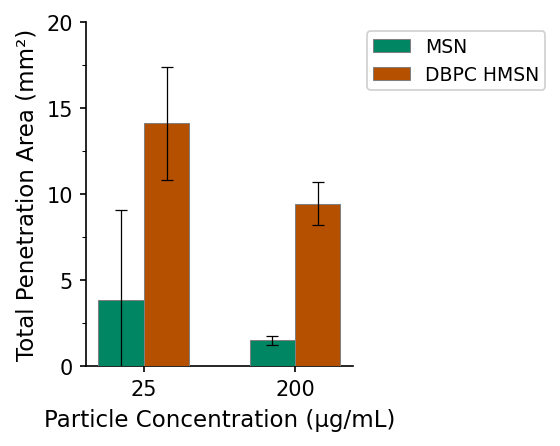


All concentration-based plots (X-axis: Concentration) created!

CREATING PARTICLE-TYPE-BASED BAR PLOTS (X-axis: Particle Type)
  Saved: particle_type_comparison_bar_0p0pct_duty_2percent.png
  Saved: particle_type_comparison_bar_0p5pct_duty_2percent.png
  Saved: particle_type_comparison_bar_1p0pct_duty_2percent.png
  Saved: particle_type_comparison_bar_2p5pct_duty_2percent.png


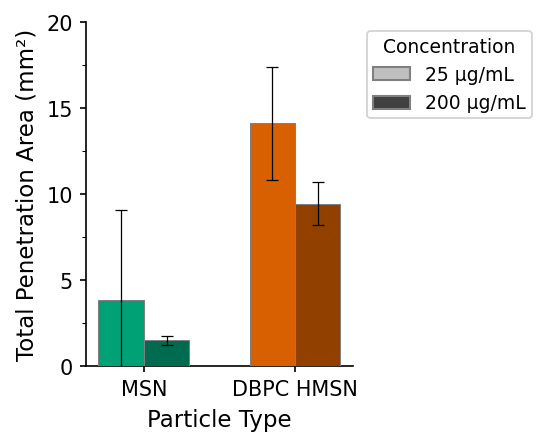


All particle-type-based plots (X-axis: Particle Type) created!

ALL PLOTS AND STATISTICAL ANALYSES COMPLETE!


In [20]:
# Penetration bar plot with duty-cycle gradient shading and statistical significance
# Uses the actual Merged_Metrics files found by Block 1 tkinter selector
# Supports 2%, 4%, and 8% gelatin with different hatch patterns
# MODIFIED: Now uses 'Total Penetration Area' and extracts particle type from file path
# MODIFIED: Added one-tailed t-test (right-tailed: DBPC HMSN > MSN)

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
import colorsys
import sys
from scipy import stats

# Check if we have metrics files from Block 1
if 'metrics_hits' not in locals():
    print("No metrics_hits found. Run Block 1 first!")
    sys.exit(1)

if not metrics_hits:
    print("No Merged_Metrics files were found in Block 1")
    sys.exit(1)

print(f"\nProcessing {len(metrics_hits)} Merged_Metrics files:")
for f in metrics_hits:
    print(f"  - {f}")

# Get save directory from the first metrics file
save_dir = metrics_hits[0].parent if metrics_hits else Path.cwd()

# ---------- CONSTANTS ----------
DC_MAP = {0: 0.0, 5: 0.5, 11: 1.0, 28: 2.5, 40: 3.6}
DUTY_ORDER_8 = [0.0, 0.5, 1.0, 2.5, 3.6]  # For 8% gelatin
DUTY_ORDER_2_4 = [0.0, 0.5, 1.0, 2.5]  # For 2% and 4% gelatin (no 3.6%)

# Duty-cycle gradient shading (matching your line plots)
SHADE_MAP = {
    0.0: 1.3,    # Lightest
    0.5: 1.15,
    1.0: 1.0,    # Base color
    2.5: 0.85,
    3.6: 0.7     # Darkest
}

FIG_W_IN, FIG_H_IN = 2.29, 2.98
YMIN = 0.0  # Y-min is always 0
BAR_WIDTH = 0.30

# Base colors for particle types
MSN_COLOR = "#009E73"      # Green
DBPC_COLOR = "#D55E00"     # Orange
HMSN_COLOR = "#0072B2"     # Blue for other types
EDGE_COLOR = "#808080"     # Gray edges

BAR_EDGE_LW = 0.5
SPINE_LW = 0.8
TICK_MAJ_LW, TICK_MIN_LW = 0.8, 0.5
TICK_FS, AXIS_FS, LEGEND_FS = 10, 11, 9

mpl.rcParams["hatch.linewidth"] = 1.0  # Standard hatch line width

# Gelatin hatching patterns
GEL_HATCH = {
    2: None,    # No hatching for 2%
    4: "/",     # Diagonal lines for 4%
    8: "x"      # X pattern for 8%
}

ERR_KW = dict(elinewidth=0.6, capsize=3, capthick=0.6, ecolor="black")

# ---------- HELPERS ----------
def apply_gradient(base_color, duty_cycle):
    """Apply gradient shading based on duty cycle"""
    intensity = SHADE_MAP.get(duty_cycle, 1.0)
    rgb = mpl.colors.to_rgb(base_color)
    h, l, s = colorsys.rgb_to_hls(*rgb)
    l = max(0, min(1, l * intensity))
    return colorsys.hls_to_rgb(h, l, s)

def get_particle_concentration(filepath):
    """Extract particle concentration (ug/mL) from full file path or filename"""
    path_str = str(filepath)
    
    # Pattern 1: From path like "25 ug-mL"
    particle_match = re.search(r'(\d+(?:\.\d+)?)\s*ug-ml', path_str, re.IGNORECASE)
    if particle_match:
        return float(particle_match.group(1))
    
    # Pattern 2: From merged filename like "Merged_Metrics_2pct_gelatin_25ugmL.xlsx"
    filename_match = re.search(r'_(\d+(?:\.\d+)?)ugml', path_str.lower())
    if filename_match:
        return float(filename_match.group(1))
    
    # Default: 200 ug/mL if not found
    return 200.0

def get_all_particle_types_from_sheets(excel_path):
    """Extract ALL particle types present in the Excel file"""
    particle_types = []
    try:
        xls = pd.ExcelFile(excel_path)
        sheet_names = xls.sheet_names
        
        # Check ALL sheets for particle type prefixes
        has_d = any(sheet.startswith('D_') for sheet in sheet_names)
        has_m = any(sheet.startswith('M_') for sheet in sheet_names)
        has_h = any(sheet.startswith('H_') for sheet in sheet_names)
        
        if has_d:
            particle_types.append('DBPC HMSN')
        if has_m:
            particle_types.append('MSN')
        if has_h:
            particle_types.append('HMSN')
            
    except Exception as e:
        print(f"    Warning: Could not read sheets from {Path(excel_path).name}: {e}")
    
    return particle_types if particle_types else ['Unknown']

def get_particle_type_from_path(filepath):
    """Extract particle type from file path"""
    path_str = str(filepath)
    if 'DBPC HMSN' in path_str or 'DBPC-HMSN' in path_str:
        return 'DBPC HMSN'
    elif 'MSN' in path_str and 'HMSN' not in path_str:
        return 'MSN'
    elif 'HMSN' in path_str and 'DBPC' not in path_str:
        return 'HMSN'
    return 'Unknown'

def get_gelatin_percentage(filepath):
    """Extract gelatin percentage from full file path"""
    path_str = str(filepath)
    
    if "2%" in path_str or "2 percent" in path_str.lower() or "2pct" in path_str.lower():
        return 2
    elif "4%" in path_str or "4 percent" in path_str.lower() or "4pct" in path_str.lower():
        return 4
    elif "8%" in path_str or "8 percent" in path_str.lower() or "8pct" in path_str.lower():
        return 8
    else:
        print(f"Warning: Could not determine gelatin percentage from path: {filepath}")
        print("Defaulting to 8%")
        return 8

def parse_sheet_name(name: str):
    """
    Parse sheet names in format:
    - New: "D_G2_P25_28C_R6" or "M_G2_P200_28C_R3"
    - Old: "28C_R1" or "5C_R3"
    Returns: (duty_cycle_percent, replicate_number)
    """
    # Try new format first: [D|M|H]_G#_P#_#C_R#
    m_new = re.match(r'^[DMH]_G\d+(?:\.\d+)?_P\d+(?:\.\d+)?_(\d+)C_R(\d+)$', 
                     str(name), flags=re.IGNORECASE)
    if m_new:
        cycles = int(m_new.group(1))
        replicate = int(m_new.group(2))
        return DC_MAP.get(cycles), replicate
    
    # Fallback to old format: #C_R#
    m_old = re.match(r"^\s*(\d+)\s*C?_R\s*(\d+)\s*$", str(name), flags=re.IGNORECASE)
    if m_old:
        return DC_MAP.get(int(m_old.group(1))), int(m_old.group(2))
    
    return None, None

def to_number_strip_mm2(val):
    if pd.isna(val): return 0.0
    if isinstance(val, (int, float, np.number)): return float(val)
    s = str(val).replace("mm²","").replace("mm^2","").replace("mm2","").strip()
    m = re.search(r"[-+]?\d*\.?\d+(?:[eE][-+]?\d+)?", s)
    return float(m.group(0)) if m else 0.0

def to_int_safe(val):
    if pd.isna(val): return 0
    try: return int(float(val))
    except: return 0

def extract_metrics_from_workbook(path: Path, concentration: float, particle_type: str) -> pd.DataFrame:
    """Extract metrics from workbook, filtering by particle type from sheet names"""
    if not path.exists():
        print(f"Warning: File does not exist: {path}")
        return pd.DataFrame(columns=["Particle","Concentration (ug/mL)","Duty Cycle (%)","Replicate",
                                     "Total Penetration Area","Particle Count"])
    
    xls = pd.ExcelFile(path)
    recs = []
    
    # Determine the prefix for this particle type
    if particle_type == 'DBPC HMSN':
        prefix = 'D_'
    elif particle_type == 'MSN':
        prefix = 'M_'
    elif particle_type == 'HMSN':
        prefix = 'H_'
    else:
        prefix = None
    
    for sheet in xls.sheet_names:
        # Skip sheets that don't match this particle type
        if prefix and not sheet.startswith(prefix):
            continue
        
        # Parse duty cycle and replicate from sheet name
        dc, rep = parse_sheet_name(sheet)
        if dc is None or rep is None:
            continue
        
        df = pd.read_excel(path, sheet_name=sheet)
        df.columns = [str(c).strip() for c in df.columns]
        metric_map = {}
        
        if "Metric" in df.columns and "Value" in df.columns:
            for _, r in df.iterrows():
                metric_map[str(r["Metric"]).strip()] = r["Value"]
        else:
            mcol, vcol = df.columns[0], (df.columns[1] if len(df.columns) > 1 else df.columns[0])
            for _, r in df.iterrows():
                metric_map[str(r[mcol]).strip()] = r[vcol]
        
        # Use Total Penetration Area as primary metric
        area_val = metric_map.get("Total Penetration Area", np.nan)
        if pd.isna(area_val):
            area_val = metric_map.get("Total Penetration Area (mm²)", np.nan)
            if pd.isna(area_val):
                area_val = metric_map.get("Penetration Region Area", np.nan)
                if pd.isna(area_val):
                    area_val = metric_map.get("Region Polygon Area", np.nan)
        
        area = to_number_strip_mm2(area_val)
        pcount = to_int_safe(metric_map.get("Particle Count", np.nan))
        
        recs.append({"Particle": particle_type, "Concentration (ug/mL)": concentration, 
                     "Duty Cycle (%)": dc, "Replicate": rep,
                     "Total Penetration Area": area, "Particle Count": pcount})
    
    out = pd.DataFrame.from_records(recs)
    return out.sort_values(["Particle","Concentration (ug/mL)","Duty Cycle (%)","Replicate"]).reset_index(drop=True)

def weighted_mean_sd(x, w):
    x = np.asarray(x, float); w = np.asarray(w, float)
    if len(x) == 0: return np.nan, np.nan
    W = w.sum()
    if W > 0:
        mu = float((w * x).sum() / W)
        var = float((w * (x - mu) ** 2).sum() / W) if len(x) > 1 else 0.0
        return mu, float(np.sqrt(max(var, 0.0)))
    # Fallback if all weights are zero
    mu = float(np.mean(x))
    sd = float(np.sqrt(np.mean((x - mu) ** 2))) if len(x) > 1 else 0.0
    return mu, sd

def get_significance_stars(p_value):
    """Return significance stars based on p-value"""
    if p_value < 0.001:
        return "***"
    elif p_value < 0.01:
        return "**"
    elif p_value < 0.05:
        return "*"
    else:
        return ""

# ---------- PROCESS FILES FROM BLOCK 1 ----------
# Determine gelatin percentage from first file's full path
gel_percentage = 8  # Default
if metrics_hits:
    gel_percentage = get_gelatin_percentage(metrics_hits[0])
    
HATCH = GEL_HATCH.get(gel_percentage, "x")
print(f"Detected {gel_percentage}% gelatin - using hatching pattern: {HATCH if HATCH else 'None'}")

# Select appropriate duty cycles based on gelatin percentage
if gel_percentage in [2, 4]:
    DUTY_ORDER = DUTY_ORDER_2_4
    print("Using duty cycles: 0%, 0.5%, 1%, 2.5% (excluding 3.6%)")
else:
    DUTY_ORDER = DUTY_ORDER_8
    print("Using duty cycles: 0%, 0.5%, 1%, 2.5%, 3.6%")

# Process each file found by Block 1
all_data = []
concentrations_found = set()

for path in metrics_hits:
    print(f"\nProcessing {path.name}")
    
    # Extract ALL particle types from file
    particle_types_in_file = get_all_particle_types_from_sheets(path)
    print(f"  Particle types found: {', '.join(particle_types_in_file)}")
    
    # Extract concentration from file path/name
    concentration = get_particle_concentration(path)
    concentrations_found.add(concentration)
    print(f"  Concentration: {concentration} ug/mL")
    
    # Process each particle type separately
    for particle_type in particle_types_in_file:
        print(f"    Processing {particle_type} data...")
        df = extract_metrics_from_workbook(path, concentration, particle_type)
        if not df.empty:
            all_data.append(df)
            print(f"      Found {len(df)} data points")

# Determine plot mode
concentrations_list = sorted(list(concentrations_found))
PLOT_BY_CONCENTRATION = len(concentrations_list) >= 2

print(f"\n{'='*60}")
if PLOT_BY_CONCENTRATION:
    print(f"DETECTED MULTIPLE CONCENTRATIONS: {concentrations_list} ug/mL")
    print("Will create concentration-comparison plots (X-axis: Concentration AND Particle Type)")
else:
    print(f"SINGLE CONCENTRATION: {concentrations_list[0]} ug/mL")
    print("Will create duty-cycle plots (X-axis: Duty Cycle)")
print(f"{'='*60}")

# Always include both MSN and DBPC HMSN in particle_types
particle_types = ["MSN", "DBPC HMSN"]

if not all_data:
    print("Warning: No data extracted from any files, will show empty plot with legend")
    combined = pd.DataFrame()
else:
    combined = pd.concat(all_data, ignore_index=True)

# Save combined data
combined_path = save_dir / f"combined_total_penetration_table_{gel_percentage}percent.csv"
combined.to_csv(combined_path, index=False)
print(f"\nSaved combined data to: {combined_path}")

# ---------- CALCULATE SUMMARY (Top 3 weighted) ----------
rows = []

if PLOT_BY_CONCENTRATION:
    # Summary by particle, concentration, and duty cycle
    for particle in particle_types:
        for conc in concentrations_list:
            for dc in DUTY_ORDER:
                if not combined.empty:
                    sub = combined[(combined["Particle"]==particle) & 
                                  (combined["Concentration (ug/mL)"]==conc) &
                                  (combined["Duty Cycle (%)"]==dc)]
                else:
                    sub = pd.DataFrame()
                    
                if sub.empty:
                    mu, sd, n_used, total_w = 0.0, 0.0, 3, 0
                else:
                    sub2 = sub.sort_values("Total Penetration Area", ascending=False).head(3)
                    mu, sd = weighted_mean_sd(sub2["Total Penetration Area"], sub2["Particle Count"])
                    n_used, total_w = len(sub2), int(sub2["Particle Count"].sum())
                
                rows.append({"Particle": particle, "Concentration (ug/mL)": conc, 
                            "Duty Cycle (%)": dc,
                            "Weighted Mean Area (mm²)": mu, "Weighted SD (mm²)": sd,
                            "Top N Used": n_used, "Total Particle Count (weights)": total_w})
else:
    # Original summary by particle and duty cycle
    for particle in particle_types:
        for dc in DUTY_ORDER:
            if not combined.empty:
                sub = combined[(combined["Particle"]==particle) & (combined["Duty Cycle (%)"]==dc)]
            else:
                sub = pd.DataFrame()
                
            if sub.empty:
                mu, sd, n_used, total_w = 0.0, 0.0, 3, 0
            else:
                sub2 = sub.sort_values("Total Penetration Area", ascending=False).head(3)
                mu, sd = weighted_mean_sd(sub2["Total Penetration Area"], sub2["Particle Count"])
                n_used, total_w = len(sub2), int(sub2["Particle Count"].sum())
            
            rows.append({"Particle": particle, "Duty Cycle (%)": dc,
                        "Weighted Mean Area (mm²)": mu, "Weighted SD (mm²)": sd,
                        "Top N Used": n_used, "Total Particle Count (weights)": total_w})

summary = pd.DataFrame(rows)

# ---------- STATISTICAL TESTING (TWO-TAILED) ----------
print("\n========== Statistical Testing (Particle Type Comparison - TWO-TAILED) ==========")
significance_results_particles_two_tailed = {}

for dc in DUTY_ORDER:
    if not combined.empty:
        msn_data = combined[(combined["Particle"]=="MSN") & (combined["Duty Cycle (%)"]==dc)]
        dbpc_data = combined[(combined["Particle"]=="DBPC HMSN") & (combined["Duty Cycle (%)"]==dc)]
    else:
        msn_data = pd.DataFrame()
        dbpc_data = pd.DataFrame()
    
    # MSN: Use zeros (negative control)
    if not msn_data.empty:
        msn_top3 = msn_data.sort_values("Total Penetration Area", ascending=False).head(3)
        msn_values = msn_top3["Total Penetration Area"].values
    else:
        msn_values = np.array([0.0, 0.0, 0.0])
    
    # DBPC HMSN: Use actual data or zeros if no penetration observed
    if not dbpc_data.empty:
        dbpc_top3 = dbpc_data.sort_values("Total Penetration Area", ascending=False).head(3)
        dbpc_values = dbpc_top3["Total Penetration Area"].values
    else:
        dbpc_values = np.array([0.0, 0.0, 0.0])
    
    # Perform two-tailed t-test
    t_stat, p_value_two_tailed = stats.ttest_ind(msn_values, dbpc_values, equal_var=False)
    stars_two_tailed = get_significance_stars(p_value_two_tailed)
    significance_results_particles_two_tailed[dc] = {"p_value": p_value_two_tailed, "stars": stars_two_tailed}
    
    print(f"Duty Cycle {dc}%: p = {p_value_two_tailed:.4f} {stars_two_tailed}")
    print(f"  MSN values (n={len(msn_values)}): {msn_values}")
    print(f"  DBPC HMSN values (n={len(dbpc_values)}): {dbpc_values}")

print("=" * 60)

# ---------- STATISTICAL TESTING (ONE-TAILED: DBPC HMSN > MSN) ----------
print("\n========== Statistical Testing (Particle Type Comparison - ONE-TAILED: DBPC HMSN > MSN) ==========")
significance_results_particles_one_tailed = {}

for dc in DUTY_ORDER:
    if not combined.empty:
        msn_data = combined[(combined["Particle"]=="MSN") & (combined["Duty Cycle (%)"]==dc)]
        dbpc_data = combined[(combined["Particle"]=="DBPC HMSN") & (combined["Duty Cycle (%)"]==dc)]
    else:
        msn_data = pd.DataFrame()
        dbpc_data = pd.DataFrame()
    
    # MSN: Use zeros (negative control)
    if not msn_data.empty:
        msn_top3 = msn_data.sort_values("Total Penetration Area", ascending=False).head(3)
        msn_values = msn_top3["Total Penetration Area"].values
    else:
        msn_values = np.array([0.0, 0.0, 0.0])
    
    # DBPC HMSN: Use actual data or zeros if no penetration observed
    if not dbpc_data.empty:
        dbpc_top3 = dbpc_data.sort_values("Total Penetration Area", ascending=False).head(3)
        dbpc_values = dbpc_top3["Total Penetration Area"].values
    else:
        dbpc_values = np.array([0.0, 0.0, 0.0])
    
    # Perform one-tailed t-test (right-tailed: testing if DBPC HMSN > MSN)
    t_stat, p_value_two_tailed = stats.ttest_ind(dbpc_values, msn_values, equal_var=False)
    # Convert to one-tailed p-value (divide by 2 if t_stat > 0, else 1 - p/2)
    if t_stat > 0:
        p_value_one_tailed = p_value_two_tailed / 2
    else:
        p_value_one_tailed = 1 - (p_value_two_tailed / 2)
    
    stars_one_tailed = get_significance_stars(p_value_one_tailed)
    significance_results_particles_one_tailed[dc] = {"p_value": p_value_one_tailed, "stars": stars_one_tailed}
    
    print(f"Duty Cycle {dc}%: p = {p_value_one_tailed:.4f} {stars_one_tailed}")
    print(f"  MSN values (n={len(msn_values)}): {msn_values}")
    print(f"  DBPC HMSN values (n={len(dbpc_values)}): {dbpc_values}")
    print(f"  t-statistic = {t_stat:.4f}")

print("=" * 60)

# Save two-tailed results
stats_df_two_tailed = pd.DataFrame([
    {"Duty Cycle (%)": dc, "p-value (two-tailed)": res["p_value"], "Significance": res["stars"]}
    for dc, res in significance_results_particles_two_tailed.items()
])
stats_path_two_tailed = save_dir / f"statistical_comparison_particle_types_{gel_percentage}percent_two_tailed.csv"
stats_df_two_tailed.to_csv(stats_path_two_tailed, index=False)
print(f"\nSaved two-tailed particle type comparison results to: {stats_path_two_tailed}")

# Save one-tailed results
stats_df_one_tailed = pd.DataFrame([
    {"Duty Cycle (%)": dc, "p-value (one-tailed)": res["p_value"], "Significance": res["stars"]}
    for dc, res in significance_results_particles_one_tailed.items()
])
stats_path_one_tailed = save_dir / f"statistical_comparison_particle_types_{gel_percentage}percent_one_tailed.csv"
stats_df_one_tailed.to_csv(stats_path_one_tailed, index=False)
print(f"Saved one-tailed particle type comparison results to: {stats_path_one_tailed}")

# ---------- STATISTICAL TESTING (Concentration Effect) ----------
if PLOT_BY_CONCENTRATION and len(concentrations_list) == 2:
    low_conc = min(concentrations_list)
    high_conc = max(concentrations_list)
    
    print("\n========== Statistical Testing (Concentration Effect - TWO-TAILED) ==========")
    significance_results_concentration_two_tailed = {}
    
    for particle in particle_types:
        significance_results_concentration_two_tailed[particle] = {}
        print(f"\n{particle}:")
        
        for dc in DUTY_ORDER:
            if not combined.empty:
                low_data = combined[(combined["Particle"]==particle) & 
                                   (combined["Concentration (ug/mL)"]==low_conc) &
                                   (combined["Duty Cycle (%)"]==dc)]
                high_data = combined[(combined["Particle"]==particle) & 
                                    (combined["Concentration (ug/mL)"]==high_conc) &
                                    (combined["Duty Cycle (%)"]==dc)]
            else:
                low_data = pd.DataFrame()
                high_data = pd.DataFrame()
            
            if not low_data.empty:
                low_top3 = low_data.sort_values("Total Penetration Area", ascending=False).head(3)
                low_values = low_top3["Total Penetration Area"].values
            else:
                low_values = np.array([0.0, 0.0, 0.0])
            
            if not high_data.empty:
                high_top3 = high_data.sort_values("Total Penetration Area", ascending=False).head(3)
                high_values = high_top3["Total Penetration Area"].values
            else:
                high_values = np.array([0.0, 0.0, 0.0])
            
            # Two-tailed test
            t_stat_two, p_value_two = stats.ttest_ind(low_values, high_values, equal_var=False)
            stars_two = get_significance_stars(p_value_two)
            significance_results_concentration_two_tailed[particle][dc] = {"p_value": p_value_two, "stars": stars_two}
            
            print(f"  Duty Cycle {dc}%: p = {p_value_two:.4f} {stars_two}")
            print(f"    {int(low_conc)} µg/mL values (n={len(low_values)}): {low_values}")
            print(f"    {int(high_conc)} µg/mL values (n={len(high_values)}): {high_values}")
    
    print("=" * 60)
    
    print("\n========== Statistical Testing (Concentration Effect - ONE-TAILED: Low Conc > High Conc) ==========")
    significance_results_concentration_one_tailed = {}
    
    for particle in particle_types:
        significance_results_concentration_one_tailed[particle] = {}
        print(f"\n{particle}:")
        
        for dc in DUTY_ORDER:
            if not combined.empty:
                low_data = combined[(combined["Particle"]==particle) & 
                                   (combined["Concentration (ug/mL)"]==low_conc) &
                                   (combined["Duty Cycle (%)"]==dc)]
                high_data = combined[(combined["Particle"]==particle) & 
                                    (combined["Concentration (ug/mL)"]==high_conc) &
                                    (combined["Duty Cycle (%)"]==dc)]
            else:
                low_data = pd.DataFrame()
                high_data = pd.DataFrame()
            
            if not low_data.empty:
                low_top3 = low_data.sort_values("Total Penetration Area", ascending=False).head(3)
                low_values = low_top3["Total Penetration Area"].values
            else:
                low_values = np.array([0.0, 0.0, 0.0])
            
            if not high_data.empty:
                high_top3 = high_data.sort_values("Total Penetration Area", ascending=False).head(3)
                high_values = high_top3["Total Penetration Area"].values
            else:
                high_values = np.array([0.0, 0.0, 0.0])
            
            # One-tailed test (testing if low_conc > high_conc, i.e., 25 > 200)
            t_stat_one, p_value_two_one = stats.ttest_ind(low_values, high_values, equal_var=False)
            if t_stat_one > 0:
                p_value_one = p_value_two_one / 2
            else:
                p_value_one = 1 - (p_value_two_one / 2)
            stars_one = get_significance_stars(p_value_one)
            significance_results_concentration_one_tailed[particle][dc] = {"p_value": p_value_one, "stars": stars_one}
            
            print(f"  Duty Cycle {dc}%: p = {p_value_one:.4f} {stars_one}")
            print(f"    {int(low_conc)} µg/mL values (n={len(low_values)}): {low_values}")
            print(f"    {int(high_conc)} µg/mL values (n={len(high_values)}): {high_values}")
            print(f"    t-statistic = {t_stat_one:.4f}")
    
    print("=" * 60)
    
    # Save concentration effect results
    conc_rows_two = []
    conc_rows_one = []
    for particle in particle_types:
        for dc in DUTY_ORDER:
            if dc in significance_results_concentration_two_tailed[particle]:
                res_two = significance_results_concentration_two_tailed[particle][dc]
                conc_rows_two.append({
                    "Particle": particle,
                    "Duty Cycle (%)": dc,
                    "p-value (two-tailed)": res_two["p_value"],
                    "Significance": res_two["stars"]
                })
                
                res_one = significance_results_concentration_one_tailed[particle][dc]
                conc_rows_one.append({
                    "Particle": particle,
                    "Duty Cycle (%)": dc,
                    "p-value (one-tailed)": res_one["p_value"],
                    "Significance": res_one["stars"]
                })
    
    conc_stats_df_two = pd.DataFrame(conc_rows_two)
    conc_stats_path_two = save_dir / f"statistical_comparison_concentration_{gel_percentage}percent_two_tailed.csv"
    conc_stats_df_two.to_csv(conc_stats_path_two, index=False)
    print(f"\nSaved two-tailed concentration comparison results to: {conc_stats_path_two}")
    
    conc_stats_df_one = pd.DataFrame(conc_rows_one)
    conc_stats_path_one = save_dir / f"statistical_comparison_concentration_{gel_percentage}percent_one_tailed.csv"
    conc_stats_df_one.to_csv(conc_stats_path_one, index=False)
    print(f"Saved one-tailed concentration comparison results to: {conc_stats_path_one}")

# Save the summary table
summary_path = save_dir / f"weighted_summary_{gel_percentage}percent.csv"
summary.to_csv(summary_path, index=False)
print(f"\nSaved summary table: {summary_path}")

# ---------- CALCULATE DYNAMIC Y-AXIS LIMIT ----------
# Calculate max value from summary (mean + SD to account for error bars)
if not summary.empty:
    max_val = (summary["Weighted Mean Area (mm²)"] + summary["Weighted SD (mm²)"]).max()
    # Add 15% padding above the highest point
    YMAX = max_val * 1.15
    # Ensure minimum y-max of 1.0 for cases with very small values
    YMAX = max(YMAX, 1.0)
else:
    YMAX = 1.0  # Default if no data

print(f"\nDynamic Y-axis range: {YMIN} to {YMAX:.2f} mm²")

# Create color map
color_map = {
    "MSN": MSN_COLOR,
    "DBPC HMSN": DBPC_COLOR,
    "HMSN": HMSN_COLOR
}

# ========= PLOTTING =========
if PLOT_BY_CONCENTRATION:
    # ========= CONCENTRATION-BASED PLOTS (X-axis: Concentration) =========
    print("\n" + "="*60)
    print("CREATING CONCENTRATION-BASED BAR PLOTS (X-axis: Concentration)")
    print("="*60)
    
    # Create one plot per duty cycle
    for dc in DUTY_ORDER:
        print(f"\nCreating plot for {dc}% duty cycle...")
        
        plt.close("all")
        fig, ax = plt.subplots(figsize=(FIG_W_IN, FIG_H_IN), dpi=150)
        x = np.arange(len(concentrations_list))
        
        # Bar positions for MSN and DBPC HMSN
        bar_positions = [-BAR_WIDTH/2, BAR_WIDTH/2]
        
        # Plot bars for each particle type
        for idx, particle in enumerate(particle_types):
            base_color = color_map.get(particle, "#0072B2")
            bar_color = apply_gradient(base_color, dc)  # Apply duty cycle gradient
            offset = bar_positions[idx]
            
            means = []
            sds = []
            
            for conc in concentrations_list:
                s = summary[(summary["Particle"]==particle) & 
                           (summary["Concentration (ug/mL)"]==conc) &
                           (summary["Duty Cycle (%)"]==dc)]
                
                if not s.empty:
                    means.append(float(s["Weighted Mean Area (mm²)"].values[0]))
                    sds.append(float(s["Weighted SD (mm²)"].values[0]))
                else:
                    means.append(0.0)
                    sds.append(0.0)
            
            # Plot bars
            ax.bar(x + offset, means, BAR_WIDTH,
                   color=bar_color,
                   edgecolor=EDGE_COLOR,
                   linewidth=BAR_EDGE_LW,
                   yerr=sds,
                   error_kw=ERR_KW,
                   hatch=HATCH,
                   label=particle,
                   zorder=3)
        
        ax.set_ylim(YMIN, YMAX)
        ax.set_xlabel("Particle Concentration (µg/mL)", fontsize=AXIS_FS)
        ax.set_ylabel("Total Penetration Area (mm²)", fontsize=AXIS_FS)
        ax.set_xticks(x)
        ax.set_xticklabels([f"{int(c)}" for c in concentrations_list], fontsize=TICK_FS)
        
        # Ticks & spines
        ax.tick_params(axis="x", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.tick_params(axis="y", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(axis="y", which="minor", direction="out", length=2, width=TICK_MIN_LW)
        
        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(SPINE_LW)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        ax.grid(False)
        
        # Legend
        leg = ax.legend(fontsize=LEGEND_FS, 
                        loc="upper left", 
                        bbox_to_anchor=(1.02, 1.0),
                        frameon=True, 
                        fancybox=True, 
                        facecolor="white", 
                        framealpha=1.0, 
                        borderpad=0.3)
        leg.get_frame().set_edgecolor("#D0D0D0")
        leg.get_frame().set_linewidth(0.8)
        
        # Save
        duty_str = str(dc).replace(".", "p")
        png = save_dir / f"concentration_comparison_bar_{duty_str}pct_duty_{gel_percentage}percent.png"
        pdf = save_dir / f"concentration_comparison_bar_{duty_str}pct_duty_{gel_percentage}percent.pdf"
        fig.savefig(png, dpi=600, bbox_inches="tight")
        fig.savefig(pdf, bbox_inches="tight")
        
        print(f"  Saved: {png.name}")
    
    plt.show()
    print("\nAll concentration-based plots (X-axis: Concentration) created!")
    
    # ========= PARTICLE-TYPE-BASED PLOTS (X-axis: Particle Type) =========
    print("\n" + "="*60)
    print("CREATING PARTICLE-TYPE-BASED BAR PLOTS (X-axis: Particle Type)")
    print("="*60)
    
    # Get concentration min/max for shading
    conc_min = min(concentrations_list)
    conc_max = max(concentrations_list)
    
    def get_concentration_shade(base_color, conc):
        """Apply concentration-based shading to color (darker for higher concentration)"""
        # Normalize concentration to 0-1 range
        if conc_max > conc_min:
            normalized = (conc - conc_min) / (conc_max - conc_min)
        else:
            normalized = 0.5
        
        # Map to intensity range: low conc = lighter (1.2), high conc = darker (0.8)
        intensity = 1.2 - (normalized * 0.4)
        
        rgb_base = mpl.colors.to_rgb(base_color)
        h, l, s = colorsys.rgb_to_hls(*rgb_base)
        l = max(0, min(1, l * intensity))
        return colorsys.hls_to_rgb(h, l, s)
    
    # Create separate plot for each duty cycle
    for dc in DUTY_ORDER:
        plt.close("all")
        fig, ax = plt.subplots(figsize=(FIG_W_IN, FIG_H_IN), dpi=150)
        
        x = np.arange(len(particle_types))
        bar_width_adj = BAR_WIDTH / len(concentrations_list) if len(concentrations_list) > 1 else BAR_WIDTH
        
        # Calculate bar offsets
        if len(concentrations_list) == 1:
            offsets = [0]
        else:
            total_width = BAR_WIDTH * (len(concentrations_list) - 1)
            offsets = np.linspace(-total_width/2, total_width/2, len(concentrations_list))
        
        legend_handles = []
        legend_labels = []
        
        # Plot bars for each concentration
        for i, conc in enumerate(concentrations_list):
            offset = offsets[i]
            means = []
            sds = []
            
            for particle in particle_types:
                s = summary[(summary["Particle"]==particle) & 
                           (summary["Concentration (ug/mL)"]==conc) & 
                           (summary["Duty Cycle (%)"]==dc)]
                if not s.empty:
                    means.append(float(s["Weighted Mean Area (mm²)"].values[0]))
                    sds.append(float(s["Weighted SD (mm²)"].values[0]))
                else:
                    means.append(0.0)
                    sds.append(0.0)
            
            # Apply duty cycle gradient AND concentration shading to each particle's base color
            bar_colors = []
            for particle in particle_types:
                base_color = color_map.get(particle, "#0072B2")
                dc_color = apply_gradient(base_color, dc)
                conc_color = get_concentration_shade(dc_color, conc)
                bar_colors.append(conc_color)
            
            # Plot bars
            for j, (mean_val, sd_val, bar_color) in enumerate(zip(means, sds, bar_colors)):
                ax.bar(x[j] + offset, mean_val, BAR_WIDTH,
                       color=bar_color,
                       edgecolor=EDGE_COLOR,
                       linewidth=BAR_EDGE_LW,
                       yerr=sd_val,
                       error_kw=ERR_KW,
                       hatch=HATCH,
                       label=f"{int(conc)} µg/mL" if j == 0 else "",
                       zorder=3)
        
        ax.set_ylim(YMIN, YMAX)
        ax.set_xlabel("Particle Type", fontsize=AXIS_FS)
        ax.set_ylabel("Total Penetration Area (mm²)", fontsize=AXIS_FS)
        ax.set_xticks(x)
        ax.set_xticklabels(particle_types, fontsize=TICK_FS)
        
        # Ticks & spines
        ax.tick_params(axis="x", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.tick_params(axis="y", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(axis="y", which="minor", direction="out", length=2, width=TICK_MIN_LW)
        
        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(SPINE_LW)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        ax.grid(False)
        
        # Create grayscale legend handles
        from matplotlib.patches import Rectangle
        legend_handles = []
        
        for conc in concentrations_list:
            # Normalize concentration to 0-1 range
            if conc_max > conc_min:
                norm_conc = (conc - conc_min) / (conc_max - conc_min)
            else:
                norm_conc = 0.5
            
            # Map to grayscale: low conc = light gray (0.75), high conc = dark gray (0.25)
            gray_value = 0.75 - (norm_conc * 0.50)
            gray_color = (gray_value, gray_value, gray_value)
            
            rect = Rectangle((0, 0), 1, 1,
                            facecolor=gray_color,
                            edgecolor=EDGE_COLOR,
                            linewidth=1.0,
                            hatch=HATCH + HATCH if HATCH else None)
            legend_handles.append(rect)
        
        legend_labels = [f"{int(conc)} µg/mL" for conc in concentrations_list]
        
        leg = ax.legend(handles=legend_handles,
                        labels=legend_labels,
                        title="Concentration",
                        fontsize=LEGEND_FS, 
                        title_fontsize=LEGEND_FS,
                        loc="upper left", 
                        bbox_to_anchor=(1.02, 1.0),
                        frameon=True, 
                        fancybox=True, 
                        facecolor="white", 
                        framealpha=1.0, 
                        borderpad=0.3)
        leg.get_frame().set_edgecolor("#D0D0D0")
        leg.get_frame().set_linewidth(0.8)
        
        # Save
        duty_str = str(dc).replace(".", "p")
        png = save_dir / f"particle_type_comparison_bar_{duty_str}pct_duty_{gel_percentage}percent.png"
        pdf = save_dir / f"particle_type_comparison_bar_{duty_str}pct_duty_{gel_percentage}percent.pdf"
        fig.savefig(png, dpi=600, bbox_inches="tight")
        fig.savefig(pdf, bbox_inches="tight")
        
        print(f"  Saved: {png.name}")
    
    plt.show()
    print("\nAll particle-type-based plots (X-axis: Particle Type) created!")

else:
    # ========= DUTY-CYCLE-BASED PLOTS (X-axis: Duty Cycle) =========
    print("\n" + "="*60)
    print("CREATING DUTY-CYCLE-BASED BAR PLOT")
    print("="*60)
    
    def vals(p):
        """Helper function to extract means and SDs for a particle type"""
        s = summary[summary["Particle"]==p].set_index("Duty Cycle (%)")
        means=[float(s.loc[d,"Weighted Mean Area (mm²)"]) if d in s.index else 0.0 for d in DUTY_ORDER]
        sds  =[float(s.loc[d,"Weighted SD (mm²)"])       if d in s.index else 0.0 for d in DUTY_ORDER]
        return means, sds
    
    # Create plot
    if particle_types:
        plt.close("all")
        fig, ax = plt.subplots(figsize=(FIG_W_IN, FIG_H_IN), dpi=150)
        x = np.arange(len(DUTY_ORDER))
        
        # Bar positions
        bar_positions = [-BAR_WIDTH/2, BAR_WIDTH/2]
        
        # Plot bars with gradient coloring
        for idx, particle in enumerate(particle_types):
            means, sds = vals(particle)
            base_color = color_map.get(particle, "#0072B2")
            offset = bar_positions[idx] if idx < len(bar_positions) else 0
            
            # Create bars with gradient based on duty cycle
            for i, (mean_val, sd_val, dc) in enumerate(zip(means, sds, DUTY_ORDER)):
                bar_color = apply_gradient(base_color, dc)
                
                ax.bar(x[i] + offset, mean_val, BAR_WIDTH,
                       color=bar_color,
                       edgecolor=EDGE_COLOR,
                       linewidth=BAR_EDGE_LW,
                       yerr=sd_val,
                       error_kw=ERR_KW,
                       hatch=HATCH,
                       zorder=3)
        
        ax.set_ylim(YMIN, YMAX)
        ax.set_xlabel("Duty Cycle (%)", fontsize=AXIS_FS)
        ax.set_ylabel("Total Penetration Area (mm²)", fontsize=AXIS_FS)
        ax.set_xticks(x)
        ax.set_xticklabels([str(d) for d in DUTY_ORDER], fontsize=TICK_FS)
        
        # Ticks & spines
        ax.tick_params(axis="x", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.tick_params(axis="y", which="major", direction="out", length=3, width=TICK_MAJ_LW, labelsize=TICK_FS)
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.tick_params(axis="y", which="minor", direction="out", length=2, width=TICK_MIN_LW)
        
        for spine in ["left", "bottom"]:
            ax.spines[spine].set_linewidth(SPINE_LW)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        
        ax.grid(False)
        
        # Create legend
        from matplotlib.patches import Rectangle
        legend_handles = []
        
        for particle in particle_types:
            base_color = color_map.get(particle, "#0072B2")
            rect = Rectangle((0, 0), 1, 1,
                            facecolor=base_color,
                            edgecolor=EDGE_COLOR,
                            linewidth=1.0,
                            hatch=HATCH + HATCH if HATCH else None,
                            label=particle)
            legend_handles.append(rect)
        
        leg = ax.legend(handles=legend_handles, 
                        fontsize=LEGEND_FS, 
                        loc="upper left", 
                        bbox_to_anchor=(1.02, 1.0),
                        frameon=True, 
                        fancybox=True, 
                        facecolor="white", 
                        framealpha=1.0, 
                        borderpad=0.3)
        leg.get_frame().set_edgecolor("#D0D0D0")
        leg.get_frame().set_linewidth(0.8)
        
        # Save
        png = save_dir / f"total_penetration_grouped_bar_{gel_percentage}percent_gradient.png"
        pdf = save_dir / f"total_penetration_grouped_bar_{gel_percentage}percent_gradient.pdf"
        fig.savefig(png, dpi=600, bbox_inches="tight")
        fig.savefig(pdf, bbox_inches="tight")
        
        print(f"\nSaved figures:")
        print(f"  - {png}")
        print(f"  - {pdf}")
        
        plt.show()
    else:
        print("No particle types found to plot!")

print("\n" + "="*60)
print("ALL PLOTS AND STATISTICAL ANALYSES COMPLETE!")
print("="*60)